## References:
1. https://www.analyticsvidhya.com/blog/2021/06/music-genres-classification-using-deep-learning-techniques/
2. https://data-flair.training/blogs/python-project-music-genre-classification/
3. https://blog.clairvoyantsoft.com/music-genre-classification-using-cnn-ef9461553726
4. https://github.com/AmbarZaidi/Audio-Genre-Classification
5. https://github.com/noahunallar/music-genre-recognition-using-neural-networks-and-k-means

In [ ]:
from google.colab import drive

drive.mount('/content/drive')

### Papers

1)
Automatic Musical Genre Classification Of Audio Signals
http://ismir2001.ismir.net/pdf/tzanetakis.pdf 

2) Feature Extraction for Musical Genre Classification (2015 ) with reference to 1 
http://hpac.rwth-aachen.de/teaching/sem-mus-15/reports/Merkelbach.pdf

3) SONG-LEVEL FEATURES AND SUPPORT VECTOR MACHINES FOR MUSIC CLASSIFICATION
https://www.ee.columbia.edu/~dpwe/pubs/ismir05-svm.pdf

4) Music Genre Classification
http://cs229.stanford.edu/proj2011/HaggbladeHongKao-MusicGenreClassification.pdf

### Libraries

python_speech_features
http://python-speech-features.readthedocs.io/en/latest/
https://github.com/jameslyons/python_speech_features


MFCC tutorial
http://webcache.googleusercontent.com/search?q=cache:BlLUHkdAU_IJ:practicalcryptography.com/miscellaneous/machine-learning/guide-mel-frequency-cepstral-coefficients-mfccs/+&cd=1&hl=en&ct=clnk&gl=in
http://www.practicalcryptography.com/miscellaneous/machine-learning/guide-mel-frequency-cepstral-coefficients-mfccs/


Reading the signal 
https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.io.wavfile.read.html

Hamming Window
https://docs.scipy.org/doc/numpy/reference/generated/numpy.hamming.html




gits: 
https://github.com/mmoksas68/Music-Genre-Classification



## Some Findings 

- **Librosa** Library is to convert the music to the **spectograms**. Each music file will be one a spectogram
- The **Wavelet** Transform is a transformation that can be used to analyze the spectral and temporal properties of non-stationary signals like audio. **Librosa** library is to generate wavelets of each audio file.
- Also librosa.display will help to display 

### Comments by the already used methods 
- We train our CNN model for 500 epochs with Adam optimizer at a learning rate of 0.0001. We use categorical cross-entropy as the loss function [1]

### Small Discussion



## Libraries 

In [2]:
import scipy.io.wavfile as wav
from tensorflow import keras  
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import matplotlib.axes as axt
from python_speech_features import mfcc
import pandas as pd
import numpy as np
from tempfile import TemporaryFile
import librosa, librosa.display
import json
import os
import math
import pickle
import random
import operator
import subprocess
from pydub.playback import play
from pydub import AudioSegment
from os import walk, listdir, chdir
from os.path import isfile, join
import scipy.io.wavfile as wav
import tensorflow as tf
from keras.utils.np_utils import to_categorical

In [2]:
# def test_song(current_song_path, next_path, genre = "pop", JSON_PATH = "/Users/ilyaskarimov/Documents/GitHub/ADA-GW-Fall2020-IlyasKarimov-/Music_Genre_Classification/testing/tmp.json"):
#     write_as_wav(current_song_path, next_path, genre)
#     save_as_mfcc(current_song_path, JSON_PATH, num_segments = 15)

In [54]:
current_song_path = "/Users/ilyaskarimov/Documents/GitHub/ADA-GW-Fall2020-IlyasKarimov-/Music_Genre_Classification/testing/jazz"
next_path = "/Users/ilyaskarimov/Documents/GitHub/ADA-GW-Fall2020-IlyasKarimov-/Music_Genre_Classification/testing/wav"

## Adding 100 songs to my data from each genre ( function )

In [57]:
def write_as_wav(new_songs_path, wav_songs_path, genre = "empty."):
    # Find those song files
    onlyfiles = [f for f in listdir(new_songs_path) if isfile(join(new_songs_path, f))]
    
    
    numb = 100
    audio_length = 30 * 1000 # in milliseconds, 30 seconds
    for f in onlyfiles: 
        filename = os.fsdecode(f)
        if filename.endswith(".mp3") or filename.endswith(".MP3"):
            xpath = os.path.join(new_songs_path,filename)
            print(xpath)
            new  = os.path.join(os.path.join(wav_songs_path),genre + str(numb).zfill(5) + ".wav" )
            audSeg = AudioSegment.from_mp3(xpath)
            audSeg = audSeg[0:audio_length]
            audSeg = audSeg.set_frame_rate(22050)
            audSeg.export(new, format="wav")
            numb = numb +  1

### Preprocessing 
Extracting data from music dataset and writing to JSON 

In [ ]:

# DATASET_PATH = "./Data/genres_original"
# JSON_PATH = "data.json_mfcc_5"
# SAMPLE_RATE = 22050
# DURATION = 30 #in seconds
# SAMPLES_PER_TRACK = SAMPLE_RATE*DURATION #22050*30

In [58]:
#num_segments is needed for NN, which needs chunks of data, rather than one full segment. 

def save_as_mfcc(dataset_path, json_path, num_mfcc = 13, n_fft = 2048, hop_length = 512, num_segments = 10):
    data = {
        "mapping": [],
        "mfcc": [],
        "labels": []
    }
    #overall number of samples per track 
    
    num_samples_per_segment = int(SAMPLES_PER_TRACK / num_segments) # 22050 * 30 / 10 
    expected_num_mfcc_vectors_per_segment = math.ceil(num_samples_per_segment/hop_length) #calculating mfcc by the hop_length (fourier shifting) and we need to ceil the value
    print(expected_num_mfcc_vectors_per_segment)
    #looping through all the genres and 
    #dirpath - current, dirnames - subfolders, filenames - all file names 
    for i, (dirpath, dirnames, filenames) in enumerate(os.walk(dataset_path)):
        
        #ensure that we're not att he root level
        if dirpath is not dataset_path:
            
            #save the semantic label, save the semantic (genre) levels
            dirpath_components = dirpath.split("/") #genre/blues will give us ["genre_original", "blues"]
            semantic_label = dirpath_components[-1] #consider the last, which is blues 
            data["mapping"].append(semantic_label)
            print("\nProcessing {}".format(semantic_label))
            
            # process files for a specific genre
            for f in filenames: 
                print(f)
                #load audio file
                file_path = os.path.join(dirpath, f) #file path for the audio file 
                if not file_path.endswith('.DS_Store'):
                    signal, sr = librosa.load(file_path, sr=SAMPLE_RATE)

                    # process segments extracting mfcc and storing data 
                    for s in range(num_segments):
                        start_sample = num_samples_per_segment * s #s=0 -> 0
                        finish_sample = start_sample + num_samples_per_segment #s=0 -> num_samples_per_segment

                        mfcc = librosa.feature.mfcc(signal[start_sample:finish_sample], sr, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)

                        mfcc = mfcc.T

                        # store mfcc for segment if it has the expected length 
                        if len(mfcc) == expected_num_mfcc_vectors_per_segment:
                            data["mfcc"].append(mfcc.tolist())
                            data["labels"].append(i-1)
                            print("{}, segment:{}".format(file_path, s+1))

    with open(json_path, "w") as fp:
        json.dump(data,fp, indent=4)
                    


In [62]:

labels = ["pop",
        "metal",
        "disco",
        "blues",
        "mugam",
        "reggae",
        "classical",
        "rock",
        "hiphop",
        "country",
        "jazz"]

In [3]:
def plot_accuracy(history):
    fig, ax = plt.subplots()

    # create accuracy sublpot
    ax.plot(history.history["accuracy"], label="train accuracy")
    ax.plot(history.history["val_accuracy"], label="test accuracy")
    ax.set_ylabel("Accuracy")
    ax.legend(loc="lower right")
    ax.set_title("Accuracy eval")

    plt.show()



In [4]:
def plot_loss(history):
    fig, ax = plt.subplots()
    
    # create error sublpot
    ax.plot(history.history["loss"], label="train error")
    ax.plot(history.history["val_loss"], label="test error")
    ax.set_ylabel("Error")
    ax.set_xlabel("Epoch")
    ax.legend(loc="upper right")
    ax.set_title("Error eval")

    plt.show()

Read Data

In [7]:
# Kaggle 
seg_30_JSON_PATH = "../input/mfc-features/mfcc_seg_30_data.json"
seg_15_JSON_PATH = "../input/mfc-features/mfcc_seg_15_data.json"
seg_10_JSON_PATH = "../input/mfc-features/mfcc_seg_10_data.json"
seg_6_JSON_PATH  = "../input/mfc-features/mfcc_seg_6_data.json"
seg_3_JSON_PATH = "../input/mfc-features/mfcc_seg_3_data.json"
seg_1_JSON_PATH =  "../input/mfc-features/mfcc_seg_1_data.json"
SAMPLE_RATE = 22050
DURATION = 30 #in seconds
SAMPLES_PER_TRACK = SAMPLE_RATE*DURATION #22050*30

In [ ]:
# Colab
seg_30_JSON_PATH = "/content/drive/MyDrive/Colab Notebooks/mfcc_seg_30_data.json"
seg_15_JSON_PATH = "/content/drive/MyDrive/Colab Notebooks/mfcc_seg_15_data.json"
seg_10_JSON_PATH = "/content/drive/MyDrive/Colab Notebooks/mfcc_seg_10_data.json"
seg_6_JSON_PATH  = "/content/drive/MyDrive/Colab Notebooks/mfcc_seg_6_data.json"
seg_3_JSON_PATH = "/content/drive/MyDrive/Colab Notebooks/mfcc_seg_3_data.json"
seg_1_JSON_PATH =  "/content/drive/MyDrive/Colab Notebooks/mfcc_seg_1_data.json"
SAMPLE_RATE = 22050
DURATION = 30 #in seconds
SAMPLES_PER_TRACK = SAMPLE_RATE*DURATION #22050*30

In [5]:
# My Mac
seg_30_JSON_PATH = "/Users/ilyaskarimov/Documents/GitHub/ADA-GW-Fall2020-IlyasKarimov-/Music_Genre_Classification/mfcc_seg_30_data.json"
seg_15_JSON_PATH = "/Users/ilyaskarimov/Documents/GitHub/ADA-GW-Fall2020-IlyasKarimov-/Music_Genre_Classification/mfcc_seg_15_data.json"
seg_10_JSON_PATH = "/Users/ilyaskarimov/Documents/GitHub/ADA-GW-Fall2020-IlyasKarimov-/Music_Genre_Classification/mfcc_seg_10_data.json"
seg_6_JSON_PATH  = "//Users/ilyaskarimov/Documents/GitHub/ADA-GW-Fall2020-IlyasKarimov-/Music_Genre_Classification/mfcc_seg_6_data.json"
seg_3_JSON_PATH = "/Users/ilyaskarimov/Documents/GitHub/ADA-GW-Fall2020-IlyasKarimov-/Music_Genre_Classification/mfcc_seg_3_data.json"
seg_1_JSON_PATH =  "/Users/ilyaskarimov/Documents/GitHub/ADA-GW-Fall2020-IlyasKarimov-/Music_Genre_Classification/mfcc_seg_1_data.json"
SAMPLE_RATE = 22050
DURATION = 30 #in seconds
SAMPLES_PER_TRACK = SAMPLE_RATE*DURATION #22050*30

In [3]:

from google.colab import drive
drive.mount('/content/drive')

ModuleNotFoundError: No module named 'google.colab'

In [6]:
with open(seg_30_JSON_PATH, "r") as fp:
    conv1d_data = json.load(fp)

In [7]:
arr = np.array(conv1d_data)

In [8]:
th_inputs = np.array(conv1d_data["mfcc"])
th_targets = np.array(conv1d_data["labels"])

In [9]:
len(th_inputs)

65901

Erasing zeros from the data and labels

In [10]:
index = 0
next_inputs = th_inputs
next_targets = th_targets
length_of_array = len(next_inputs)
while index != len(next_inputs) - 1:
    print(index, len(next_inputs))
    if(0.0 in next_inputs[index]):
        next_inputs =np.delete(next_inputs, index, 0)
        next_targets = np.delete(next_targets, index, 0)
        index = index - 1
    index = index + 1

0 65901
0 65900
1 65900
2 65900
3 65900
4 65900
5 65900
6 65900
7 65900
8 65900
9 65900
10 65900
11 65900
12 65900
13 65900
14 65900
15 65900
16 65900
17 65900
18 65900
19 65900
20 65900
21 65900
22 65900
23 65900
24 65900
25 65900
26 65900
27 65900
28 65900
29 65900
29 65899
30 65899
31 65899
32 65899
33 65899
34 65899
35 65899
36 65899
37 65899
38 65899
39 65899
40 65899
41 65899
42 65899
43 65899
44 65899
45 65899
46 65899
47 65899
48 65899
49 65899
50 65899
51 65899
52 65899
53 65899
54 65899
55 65899
56 65899
57 65899
58 65899
58 65898
59 65898
60 65898
61 65898
62 65898
63 65898
64 65898
65 65898
66 65898
67 65898
68 65898
69 65898
70 65898
71 65898
72 65898
73 65898
74 65898
75 65898
76 65898
77 65898
78 65898
79 65898
80 65898
81 65898
82 65898
83 65898
84 65898
85 65898
86 65898
87 65898
87 65897
88 65897
89 65897
90 65897
91 65897
92 65897
93 65897
94 65897
95 65897
96 65897
97 65897
98 65897
99 65897
100 65897
101 65897
102 65897
103 65897
104 65897
105 65897
106 65897
107 6

858 65888
859 65888
860 65888
861 65888
862 65888
863 65888
864 65888
865 65888
866 65888
867 65888
868 65888
869 65888
870 65888
871 65888
872 65888
873 65888
874 65888
875 65888
876 65888
877 65888
878 65888
879 65888
880 65888
881 65888
882 65888
883 65888
884 65888
885 65888
886 65888
887 65888
887 65887
888 65887
889 65887
890 65887
891 65887
892 65887
893 65887
894 65887
895 65887
896 65887
897 65887
898 65887
899 65887
900 65887
901 65887
902 65887
903 65887
904 65887
905 65887
906 65887
907 65887
908 65887
909 65887
910 65887
911 65887
912 65887
913 65887
914 65887
915 65887
916 65887
916 65886
917 65886
918 65886
919 65886
920 65886
921 65886
922 65886
923 65886
924 65886
925 65886
926 65886
927 65886
928 65886
929 65886
930 65886
931 65886
932 65886
933 65886
934 65886
935 65886
936 65886
937 65886
938 65886
939 65886
940 65886
941 65886
942 65886
943 65886
944 65886
945 65886
945 65885
946 65885
947 65885
948 65885
949 65885
950 65885
951 65885
952 65885
953 65885
954 65885


1657 65877
1658 65877
1659 65877
1660 65877
1661 65877
1662 65877
1663 65877
1664 65877
1665 65877
1666 65877
1667 65877
1668 65877
1669 65877
1670 65877
1671 65877
1672 65877
1673 65877
1674 65877
1675 65877
1676 65877
1677 65877
1678 65877
1679 65877
1680 65877
1681 65877
1682 65877
1683 65877
1684 65877
1685 65877
1686 65877
1686 65876
1687 65876
1688 65876
1689 65876
1690 65876
1691 65876
1692 65876
1693 65876
1694 65876
1695 65876
1696 65876
1697 65876
1698 65876
1699 65876
1700 65876
1701 65876
1702 65876
1703 65876
1704 65876
1705 65876
1706 65876
1707 65876
1708 65876
1709 65876
1710 65876
1711 65876
1712 65876
1713 65876
1714 65876
1715 65876
1716 65876
1717 65876
1718 65876
1719 65876
1720 65876
1721 65876
1722 65876
1723 65876
1724 65876
1725 65876
1726 65876
1727 65876
1728 65876
1729 65876
1730 65876
1731 65876
1732 65876
1733 65876
1734 65876
1735 65876
1736 65876
1737 65876
1738 65876
1739 65876
1740 65876
1741 65876
1742 65876
1743 65876
1744 65876
1745 65876
1746 65876

2493 65873
2494 65873
2495 65873
2496 65873
2497 65873
2498 65873
2499 65873
2500 65873
2501 65873
2502 65873
2503 65873
2504 65873
2505 65873
2506 65873
2507 65873
2508 65873
2509 65873
2510 65873
2511 65873
2512 65873
2513 65873
2514 65873
2515 65873
2516 65873
2517 65873
2518 65873
2519 65873
2520 65873
2521 65873
2522 65873
2522 65872
2523 65872
2524 65872
2525 65872
2526 65872
2527 65872
2528 65872
2529 65872
2530 65872
2531 65872
2532 65872
2533 65872
2534 65872
2535 65872
2536 65872
2537 65872
2538 65872
2539 65872
2540 65872
2541 65872
2542 65872
2543 65872
2544 65872
2545 65872
2546 65872
2547 65872
2548 65872
2549 65872
2550 65872
2551 65872
2552 65872
2553 65872
2554 65872
2555 65872
2556 65872
2557 65872
2558 65872
2559 65872
2560 65872
2561 65872
2562 65872
2563 65872
2564 65872
2565 65872
2566 65872
2567 65872
2568 65872
2569 65872
2570 65872
2571 65872
2572 65872
2573 65872
2574 65872
2575 65872
2576 65872
2577 65872
2578 65872
2579 65872
2580 65872
2581 65872
2582 65872

3295 65865
3296 65865
3297 65865
3298 65865
3299 65865
3300 65865
3301 65865
3302 65865
3303 65865
3304 65865
3305 65865
3306 65865
3307 65865
3308 65865
3309 65865
3310 65865
3311 65865
3312 65865
3313 65865
3314 65865
3315 65865
3316 65865
3317 65865
3318 65865
3319 65865
3320 65865
3321 65865
3322 65865
3323 65865
3324 65865
3324 65864
3325 65864
3326 65864
3327 65864
3328 65864
3329 65864
3330 65864
3331 65864
3332 65864
3333 65864
3334 65864
3335 65864
3336 65864
3337 65864
3338 65864
3339 65864
3340 65864
3341 65864
3342 65864
3343 65864
3344 65864
3345 65864
3346 65864
3347 65864
3348 65864
3349 65864
3350 65864
3351 65864
3352 65864
3353 65864
3353 65863
3354 65863
3355 65863
3356 65863
3357 65863
3358 65863
3359 65863
3360 65863
3361 65863
3362 65863
3363 65863
3364 65863
3365 65863
3366 65863
3367 65863
3368 65863
3369 65863
3370 65863
3371 65863
3372 65863
3373 65863
3374 65863
3375 65863
3376 65863
3377 65863
3378 65863
3379 65863
3380 65863
3381 65863
3382 65863
3383 65863

4214 65854
4215 65854
4216 65854
4217 65854
4218 65854
4219 65854
4220 65854
4221 65854
4222 65854
4223 65854
4224 65854
4225 65854
4226 65854
4227 65854
4228 65854
4229 65854
4230 65854
4231 65854
4232 65854
4233 65854
4234 65854
4235 65854
4236 65854
4237 65854
4238 65854
4239 65854
4240 65854
4241 65854
4242 65854
4243 65854
4244 65854
4245 65854
4246 65854
4247 65854
4248 65854
4249 65854
4250 65854
4251 65854
4252 65854
4253 65854
4254 65854
4255 65854
4256 65854
4257 65854
4258 65854
4259 65854
4260 65854
4261 65854
4262 65854
4263 65854
4264 65854
4265 65854
4266 65854
4267 65854
4268 65854
4269 65854
4270 65854
4271 65854
4272 65854
4273 65854
4273 65853
4274 65853
4275 65853
4276 65853
4277 65853
4278 65853
4279 65853
4280 65853
4281 65853
4282 65853
4283 65853
4284 65853
4285 65853
4286 65853
4287 65853
4288 65853
4289 65853
4290 65853
4291 65853
4292 65853
4293 65853
4294 65853
4295 65853
4296 65853
4297 65853
4298 65853
4299 65853
4300 65853
4301 65853
4302 65853
4302 65852

4955 65845
4956 65845
4957 65845
4958 65845
4959 65845
4960 65845
4961 65845
4962 65845
4963 65845
4964 65845
4965 65845
4966 65845
4967 65845
4968 65845
4969 65845
4970 65845
4971 65845
4972 65845
4973 65845
4974 65845
4975 65845
4976 65845
4977 65845
4978 65845
4979 65845
4980 65845
4981 65845
4982 65845
4983 65845
4984 65845
4984 65844
4985 65844
4986 65844
4987 65844
4988 65844
4989 65844
4990 65844
4991 65844
4992 65844
4993 65844
4994 65844
4995 65844
4996 65844
4997 65844
4998 65844
4999 65844
5000 65844
5001 65844
5002 65844
5003 65844
5004 65844
5005 65844
5006 65844
5007 65844
5008 65844
5009 65844
5010 65844
5011 65844
5012 65844
5013 65844
5014 65844
5015 65844
5016 65844
5017 65844
5018 65844
5019 65844
5020 65844
5021 65844
5022 65844
5023 65844
5024 65844
5025 65844
5026 65844
5027 65844
5028 65844
5029 65844
5030 65844
5031 65844
5032 65844
5033 65844
5034 65844
5035 65844
5036 65844
5037 65844
5038 65844
5039 65844
5040 65844
5041 65844
5042 65844
5043 65844
5044 65844

5694 65834
5695 65834
5696 65834
5697 65834
5698 65834
5699 65834
5700 65834
5701 65834
5702 65834
5703 65834
5704 65834
5705 65834
5706 65834
5707 65834
5708 65834
5709 65834
5710 65834
5711 65834
5712 65834
5713 65834
5714 65834
5715 65834
5716 65834
5717 65834
5718 65834
5719 65834
5720 65834
5721 65834
5722 65834
5723 65834
5724 65834
5725 65834
5726 65834
5727 65834
5728 65834
5729 65834
5730 65834
5731 65834
5732 65834
5733 65834
5734 65834
5735 65834
5736 65834
5737 65834
5738 65834
5739 65834
5740 65834
5741 65834
5742 65834
5743 65834
5744 65834
5745 65834
5746 65834
5747 65834
5748 65834
5749 65834
5750 65834
5751 65834
5752 65834
5753 65834
5754 65834
5755 65834
5756 65834
5757 65834
5758 65834
5759 65834
5760 65834
5761 65834
5762 65834
5763 65834
5764 65834
5765 65834
5766 65834
5767 65834
5768 65834
5769 65834
5770 65834
5771 65834
5772 65834
5773 65834
5774 65834
5775 65834
5776 65834
5777 65834
5778 65834
5779 65834
5780 65834
5781 65834
5782 65834
5783 65834
5784 65834

6434 65824
6435 65824
6436 65824
6437 65824
6438 65824
6439 65824
6440 65824
6441 65824
6442 65824
6443 65824
6444 65824
6445 65824
6446 65824
6447 65824
6448 65824
6449 65824
6450 65824
6451 65824
6452 65824
6453 65824
6454 65824
6455 65824
6456 65824
6457 65824
6458 65824
6459 65824
6460 65824
6461 65824
6462 65824
6463 65824
6464 65824
6465 65824
6466 65824
6467 65824
6468 65824
6469 65824
6470 65824
6471 65824
6472 65824
6473 65824
6474 65824
6475 65824
6476 65824
6477 65824
6478 65824
6479 65824
6480 65824
6481 65824
6482 65824
6483 65824
6484 65824
6485 65824
6486 65824
6487 65824
6488 65824
6489 65824
6490 65824
6491 65824
6492 65824
6493 65824
6494 65824
6495 65824
6496 65824
6497 65824
6498 65824
6499 65824
6500 65824
6501 65824
6502 65824
6503 65824
6504 65824
6505 65824
6506 65824
6507 65824
6508 65824
6509 65824
6510 65824
6511 65824
6512 65824
6513 65824
6514 65824
6515 65824
6516 65824
6517 65824
6518 65824
6519 65824
6520 65824
6521 65824
6522 65824
6523 65824
6524 65824

7324 65814
7325 65814
7326 65814
7327 65814
7328 65814
7329 65814
7330 65814
7331 65814
7332 65814
7333 65814
7334 65814
7335 65814
7336 65814
7337 65814
7338 65814
7339 65814
7340 65814
7341 65814
7342 65814
7343 65814
7344 65814
7345 65814
7346 65814
7347 65814
7348 65814
7349 65814
7350 65814
7351 65814
7352 65814
7353 65814
7354 65814
7355 65814
7356 65814
7357 65814
7358 65814
7359 65814
7360 65814
7361 65814
7362 65814
7363 65814
7364 65814
7365 65814
7366 65814
7367 65814
7368 65814
7369 65814
7370 65814
7371 65814
7372 65814
7373 65814
7374 65814
7375 65814
7376 65814
7377 65814
7378 65814
7379 65814
7380 65814
7381 65814
7382 65814
7383 65814
7383 65813
7384 65813
7385 65813
7386 65813
7387 65813
7388 65813
7389 65813
7390 65813
7391 65813
7392 65813
7393 65813
7394 65813
7395 65813
7396 65813
7397 65813
7398 65813
7399 65813
7400 65813
7401 65813
7402 65813
7403 65813
7404 65813
7405 65813
7406 65813
7407 65813
7408 65813
7409 65813
7410 65813
7411 65813
7412 65813
7412 65812

8186 65806
8186 65805
8187 65805
8188 65805
8189 65805
8190 65805
8191 65805
8192 65805
8193 65805
8194 65805
8195 65805
8196 65805
8197 65805
8198 65805
8199 65805
8200 65805
8201 65805
8202 65805
8203 65805
8204 65805
8205 65805
8206 65805
8207 65805
8208 65805
8209 65805
8210 65805
8211 65805
8212 65805
8213 65805
8214 65805
8215 65805
8216 65805
8217 65805
8218 65805
8219 65805
8220 65805
8221 65805
8222 65805
8223 65805
8224 65805
8225 65805
8226 65805
8227 65805
8228 65805
8229 65805
8230 65805
8231 65805
8232 65805
8233 65805
8234 65805
8235 65805
8236 65805
8237 65805
8238 65805
8239 65805
8240 65805
8241 65805
8242 65805
8243 65805
8244 65805
8245 65805
8246 65805
8247 65805
8248 65805
8249 65805
8250 65805
8251 65805
8252 65805
8253 65805
8254 65805
8255 65805
8256 65805
8257 65805
8258 65805
8259 65805
8260 65805
8261 65805
8262 65805
8263 65805
8264 65805
8265 65805
8266 65805
8267 65805
8268 65805
8269 65805
8270 65805
8271 65805
8272 65805
8273 65805
8274 65805
8274 65804

8991 65801
8992 65801
8993 65801
8994 65801
8995 65801
8996 65801
8997 65801
8998 65801
8999 65801
9000 65801
9001 65801
9002 65801
9003 65801
9004 65801
9005 65801
9006 65801
9007 65801
9008 65801
9009 65801
9010 65801
9011 65801
9012 65801
9013 65801
9014 65801
9015 65801
9016 65801
9017 65801
9018 65801
9019 65801
9020 65801
9020 65800
9021 65800
9022 65800
9023 65800
9024 65800
9025 65800
9026 65800
9027 65800
9028 65800
9029 65800
9030 65800
9031 65800
9032 65800
9033 65800
9034 65800
9035 65800
9036 65800
9037 65800
9038 65800
9039 65800
9040 65800
9041 65800
9042 65800
9043 65800
9044 65800
9045 65800
9046 65800
9047 65800
9048 65800
9049 65800
9050 65800
9051 65800
9052 65800
9053 65800
9054 65800
9055 65800
9056 65800
9057 65800
9058 65800
9059 65800
9060 65800
9061 65800
9062 65800
9063 65800
9064 65800
9065 65800
9066 65800
9067 65800
9068 65800
9069 65800
9070 65800
9071 65800
9072 65800
9073 65800
9074 65800
9075 65800
9076 65800
9077 65800
9078 65800
9079 65800
9079 65799

9795 65795
9796 65795
9797 65795
9798 65795
9799 65795
9800 65795
9801 65795
9802 65795
9803 65795
9804 65795
9805 65795
9806 65795
9807 65795
9808 65795
9809 65795
9810 65795
9811 65795
9812 65795
9813 65795
9814 65795
9815 65795
9816 65795
9817 65795
9818 65795
9819 65795
9820 65795
9821 65795
9822 65795
9823 65795
9824 65795
9825 65795
9826 65795
9827 65795
9828 65795
9829 65795
9830 65795
9831 65795
9832 65795
9833 65795
9834 65795
9835 65795
9836 65795
9837 65795
9838 65795
9839 65795
9840 65795
9841 65795
9842 65795
9843 65795
9844 65795
9845 65795
9846 65795
9847 65795
9848 65795
9849 65795
9850 65795
9851 65795
9852 65795
9853 65795
9854 65795
9855 65795
9856 65795
9857 65795
9858 65795
9859 65795
9860 65795
9861 65795
9862 65795
9863 65795
9864 65795
9865 65795
9866 65795
9867 65795
9868 65795
9869 65795
9870 65795
9871 65795
9872 65795
9873 65795
9874 65795
9875 65795
9876 65795
9877 65795
9878 65795
9879 65795
9880 65795
9881 65795
9882 65795
9883 65795
9884 65795
9885 65795

10659 65789
10660 65789
10661 65789
10662 65789
10663 65789
10664 65789
10665 65789
10666 65789
10667 65789
10668 65789
10669 65789
10670 65789
10671 65789
10672 65789
10673 65789
10674 65789
10675 65789
10676 65789
10677 65789
10678 65789
10679 65789
10680 65789
10681 65789
10682 65789
10683 65789
10684 65789
10685 65789
10686 65789
10687 65789
10688 65789
10688 65788
10689 65788
10690 65788
10691 65788
10692 65788
10693 65788
10694 65788
10695 65788
10696 65788
10697 65788
10698 65788
10699 65788
10700 65788
10701 65788
10702 65788
10703 65788
10704 65788
10705 65788
10706 65788
10707 65788
10708 65788
10709 65788
10710 65788
10711 65788
10712 65788
10713 65788
10714 65788
10715 65788
10716 65788
10717 65788
10717 65787
10718 65787
10719 65787
10720 65787
10721 65787
10722 65787
10723 65787
10724 65787
10725 65787
10726 65787
10727 65787
10728 65787
10729 65787
10730 65787
10731 65787
10732 65787
10733 65787
10734 65787
10735 65787
10736 65787
10737 65787
10738 65787
10739 65787
1074

11367 65777
11368 65777
11369 65777
11370 65777
11371 65777
11372 65777
11373 65777
11374 65777
11375 65777
11376 65777
11377 65777
11378 65777
11379 65777
11380 65777
11381 65777
11382 65777
11383 65777
11384 65777
11385 65777
11386 65777
11387 65777
11388 65777
11389 65777
11390 65777
11391 65777
11392 65777
11393 65777
11394 65777
11395 65777
11396 65777
11397 65777
11398 65777
11399 65777
11400 65777
11401 65777
11402 65777
11403 65777
11404 65777
11405 65777
11406 65777
11407 65777
11408 65777
11409 65777
11410 65777
11411 65777
11412 65777
11413 65777
11414 65777
11415 65777
11416 65777
11417 65777
11418 65777
11419 65777
11420 65777
11421 65777
11422 65777
11423 65777
11424 65777
11425 65777
11426 65777
11427 65777
11428 65777
11429 65777
11430 65777
11431 65777
11432 65777
11433 65777
11434 65777
11435 65777
11436 65777
11437 65777
11438 65777
11439 65777
11440 65777
11441 65777
11442 65777
11443 65777
11444 65777
11445 65777
11446 65777
11447 65777
11448 65777
11449 65777
1145

12077 65767
12078 65767
12079 65767
12080 65767
12081 65767
12082 65767
12083 65767
12084 65767
12085 65767
12086 65767
12087 65767
12088 65767
12089 65767
12090 65767
12091 65767
12092 65767
12093 65767
12094 65767
12095 65767
12096 65767
12097 65767
12098 65767
12099 65767
12100 65767
12101 65767
12102 65767
12103 65767
12104 65767
12105 65767
12106 65767
12107 65767
12108 65767
12109 65767
12110 65767
12111 65767
12112 65767
12113 65767
12114 65767
12115 65767
12116 65767
12117 65767
12118 65767
12119 65767
12120 65767
12121 65767
12122 65767
12123 65767
12124 65767
12125 65767
12126 65767
12127 65767
12128 65767
12129 65767
12130 65767
12131 65767
12132 65767
12133 65767
12134 65767
12135 65767
12136 65767
12137 65767
12138 65767
12139 65767
12140 65767
12141 65767
12142 65767
12143 65767
12144 65767
12145 65767
12146 65767
12147 65767
12148 65767
12149 65767
12150 65767
12151 65767
12152 65767
12153 65767
12154 65767
12155 65767
12156 65767
12157 65767
12158 65767
12159 65767
1216

12881 65761
12882 65761
12883 65761
12884 65761
12885 65761
12886 65761
12887 65761
12888 65761
12889 65761
12890 65761
12891 65761
12892 65761
12893 65761
12894 65761
12895 65761
12896 65761
12897 65761
12898 65761
12899 65761
12900 65761
12901 65761
12902 65761
12903 65761
12904 65761
12905 65761
12906 65761
12907 65761
12908 65761
12909 65761
12910 65761
12910 65760
12910 65759
12911 65759
12912 65759
12913 65759
12914 65759
12915 65759
12916 65759
12917 65759
12918 65759
12919 65759
12920 65759
12921 65759
12922 65759
12923 65759
12924 65759
12925 65759
12926 65759
12927 65759
12928 65759
12929 65759
12930 65759
12931 65759
12932 65759
12933 65759
12934 65759
12935 65759
12936 65759
12937 65759
12938 65759
12938 65758
12939 65758
12940 65758
12941 65758
12942 65758
12943 65758
12944 65758
12945 65758
12946 65758
12947 65758
12948 65758
12949 65758
12950 65758
12951 65758
12952 65758
12953 65758
12954 65758
12955 65758
12956 65758
12957 65758
12958 65758
12959 65758
12960 65758
1296

13621 65751
13622 65751
13623 65751
13624 65751
13625 65751
13626 65751
13627 65751
13628 65751
13629 65751
13630 65751
13631 65751
13632 65751
13633 65751
13634 65751
13635 65751
13636 65751
13637 65751
13638 65751
13639 65751
13640 65751
13641 65751
13642 65751
13643 65751
13644 65751
13645 65751
13646 65751
13647 65751
13648 65751
13649 65751
13650 65751
13650 65750
13651 65750
13652 65750
13653 65750
13654 65750
13655 65750
13656 65750
13657 65750
13658 65750
13659 65750
13660 65750
13661 65750
13662 65750
13663 65750
13664 65750
13665 65750
13666 65750
13667 65750
13668 65750
13669 65750
13670 65750
13671 65750
13672 65750
13673 65750
13674 65750
13675 65750
13676 65750
13677 65750
13678 65750
13679 65750
13679 65749
13680 65749
13681 65749
13682 65749
13683 65749
13684 65749
13685 65749
13686 65749
13687 65749
13688 65749
13689 65749
13690 65749
13691 65749
13692 65749
13693 65749
13694 65749
13695 65749
13696 65749
13697 65749
13698 65749
13699 65749
13700 65749
13701 65749
1370

14445 65735
14446 65735
14447 65735
14448 65735
14449 65735
14450 65735
14451 65735
14452 65735
14453 65735
14454 65735
14455 65735
14456 65735
14457 65735
14458 65735
14459 65735
14460 65735
14461 65735
14462 65735
14463 65735
14464 65735
14465 65735
14466 65735
14467 65735
14468 65735
14469 65735
14470 65735
14471 65735
14472 65735
14473 65735
14474 65735
14474 65734
14475 65734
14476 65734
14477 65734
14478 65734
14479 65734
14480 65734
14481 65734
14482 65734
14483 65734
14484 65734
14485 65734
14486 65734
14487 65734
14488 65734
14489 65734
14490 65734
14491 65734
14492 65734
14493 65734
14494 65734
14495 65734
14496 65734
14497 65734
14498 65734
14499 65734
14500 65734
14501 65734
14502 65734
14503 65734
14503 65733
14504 65733
14505 65733
14506 65733
14507 65733
14508 65733
14509 65733
14510 65733
14511 65733
14512 65733
14513 65733
14514 65733
14515 65733
14516 65733
14517 65733
14518 65733
14519 65733
14520 65733
14521 65733
14522 65733
14523 65733
14524 65733
14525 65733
1452

15361 65721
15362 65721
15363 65721
15364 65721
15365 65721
15366 65721
15367 65721
15368 65721
15369 65721
15370 65721
15371 65721
15372 65721
15373 65721
15374 65721
15375 65721
15376 65721
15377 65721
15378 65721
15379 65721
15380 65721
15381 65721
15382 65721
15383 65721
15384 65721
15385 65721
15386 65721
15387 65721
15388 65721
15389 65721
15390 65721
15390 65720
15391 65720
15392 65720
15393 65720
15394 65720
15395 65720
15396 65720
15397 65720
15398 65720
15399 65720
15400 65720
15401 65720
15402 65720
15403 65720
15404 65720
15405 65720
15406 65720
15407 65720
15408 65720
15409 65720
15410 65720
15411 65720
15412 65720
15413 65720
15414 65720
15415 65720
15416 65720
15417 65720
15418 65720
15419 65720
15419 65719
15420 65719
15421 65719
15422 65719
15423 65719
15424 65719
15425 65719
15426 65719
15427 65719
15428 65719
15429 65719
15430 65719
15431 65719
15432 65719
15433 65719
15434 65719
15435 65719
15436 65719
15437 65719
15438 65719
15439 65719
15440 65719
15441 65719
1544

16041 65711
16042 65711
16043 65711
16044 65711
16045 65711
16046 65711
16047 65711
16048 65711
16049 65711
16050 65711
16051 65711
16052 65711
16053 65711
16054 65711
16055 65711
16056 65711
16057 65711
16058 65711
16059 65711
16060 65711
16061 65711
16062 65711
16063 65711
16064 65711
16065 65711
16066 65711
16067 65711
16068 65711
16069 65711
16070 65711
16071 65711
16072 65711
16073 65711
16074 65711
16075 65711
16076 65711
16077 65711
16078 65711
16079 65711
16080 65711
16081 65711
16082 65711
16083 65711
16084 65711
16085 65711
16086 65711
16087 65711
16088 65711
16089 65711
16090 65711
16091 65711
16092 65711
16093 65711
16094 65711
16095 65711
16096 65711
16097 65711
16098 65711
16099 65711
16100 65711
16101 65711
16102 65711
16103 65711
16104 65711
16105 65711
16106 65711
16107 65711
16108 65711
16109 65711
16110 65711
16111 65711
16112 65711
16113 65711
16114 65711
16115 65711
16116 65711
16117 65711
16118 65711
16119 65711
16120 65711
16121 65711
16122 65711
16123 65711
1612

16870 65701
16871 65701
16872 65701
16873 65701
16874 65701
16875 65701
16876 65701
16877 65701
16878 65701
16879 65701
16880 65701
16881 65701
16882 65701
16883 65701
16884 65701
16885 65701
16886 65701
16887 65701
16888 65701
16889 65701
16890 65701
16891 65701
16892 65701
16893 65701
16894 65701
16895 65701
16896 65701
16897 65701
16898 65701
16899 65701
16899 65700
16900 65700
16901 65700
16902 65700
16903 65700
16904 65700
16905 65700
16906 65700
16907 65700
16908 65700
16909 65700
16910 65700
16911 65700
16912 65700
16913 65700
16914 65700
16915 65700
16916 65700
16917 65700
16918 65700
16919 65700
16920 65700
16921 65700
16922 65700
16923 65700
16924 65700
16925 65700
16926 65700
16927 65700
16928 65700
16928 65699
16929 65699
16930 65699
16931 65699
16932 65699
16933 65699
16934 65699
16935 65699
16936 65699
16937 65699
16938 65699
16939 65699
16940 65699
16941 65699
16942 65699
16943 65699
16944 65699
16945 65699
16946 65699
16947 65699
16948 65699
16949 65699
16950 65699
1695

17578 65689
17579 65689
17580 65689
17581 65689
17582 65689
17583 65689
17584 65689
17585 65689
17586 65689
17587 65689
17588 65689
17589 65689
17590 65689
17591 65689
17592 65689
17593 65689
17594 65689
17595 65689
17596 65689
17597 65689
17598 65689
17599 65689
17600 65689
17601 65689
17602 65689
17603 65689
17604 65689
17605 65689
17606 65689
17607 65689
17607 65688
17608 65688
17609 65688
17610 65688
17611 65688
17612 65688
17613 65688
17614 65688
17615 65688
17616 65688
17617 65688
17618 65688
17619 65688
17620 65688
17621 65688
17622 65688
17623 65688
17624 65688
17625 65688
17626 65688
17627 65688
17628 65688
17629 65688
17630 65688
17631 65688
17632 65688
17633 65688
17634 65688
17635 65688
17636 65688
17636 65687
17637 65687
17638 65687
17639 65687
17640 65687
17641 65687
17642 65687
17643 65687
17644 65687
17645 65687
17646 65687
17647 65687
17648 65687
17649 65687
17650 65687
17651 65687
17652 65687
17653 65687
17654 65687
17655 65687
17656 65687
17657 65687
17658 65687
1765

18261 65682
18262 65682
18263 65682
18264 65682
18265 65682
18266 65682
18267 65682
18268 65682
18269 65682
18270 65682
18271 65682
18272 65682
18273 65682
18274 65682
18275 65682
18276 65682
18277 65682
18278 65682
18279 65682
18280 65682
18281 65682
18282 65682
18283 65682
18284 65682
18285 65682
18286 65682
18287 65682
18288 65682
18289 65682
18290 65682
18291 65682
18292 65682
18293 65682
18294 65682
18295 65682
18296 65682
18297 65682
18298 65682
18299 65682
18300 65682
18301 65682
18302 65682
18303 65682
18304 65682
18305 65682
18306 65682
18307 65682
18308 65682
18309 65682
18310 65682
18311 65682
18312 65682
18313 65682
18314 65682
18315 65682
18316 65682
18317 65682
18318 65682
18319 65682
18320 65682
18321 65682
18322 65682
18323 65682
18324 65682
18325 65682
18326 65682
18327 65682
18328 65682
18329 65682
18330 65682
18331 65682
18332 65682
18333 65682
18334 65682
18335 65682
18336 65682
18337 65682
18338 65682
18339 65682
18340 65682
18341 65682
18342 65682
18343 65682
1834

18947 65678
18948 65678
18949 65678
18950 65678
18951 65678
18952 65678
18953 65678
18954 65678
18955 65678
18956 65678
18957 65678
18958 65678
18959 65678
18960 65678
18961 65678
18962 65678
18963 65678
18964 65678
18965 65678
18966 65678
18967 65678
18968 65678
18969 65678
18970 65678
18971 65678
18972 65678
18973 65678
18974 65678
18975 65678
18976 65678
18977 65678
18978 65678
18979 65678
18980 65678
18981 65678
18982 65678
18983 65678
18984 65678
18985 65678
18986 65678
18987 65678
18988 65678
18989 65678
18990 65678
18991 65678
18992 65678
18993 65678
18994 65678
18995 65678
18996 65678
18997 65678
18998 65678
18999 65678
19000 65678
19001 65678
19002 65678
19003 65678
19004 65678
19005 65678
19006 65678
19006 65677
19007 65677
19008 65677
19009 65677
19010 65677
19011 65677
19012 65677
19013 65677
19014 65677
19015 65677
19016 65677
19017 65677
19018 65677
19019 65677
19020 65677
19021 65677
19022 65677
19023 65677
19024 65677
19025 65677
19026 65677
19027 65677
19028 65677
1902

19688 65669
19689 65669
19690 65669
19691 65669
19692 65669
19693 65669
19694 65669
19695 65669
19696 65669
19697 65669
19698 65669
19699 65669
19700 65669
19701 65669
19702 65669
19703 65669
19704 65669
19705 65669
19706 65669
19707 65669
19708 65669
19709 65669
19710 65669
19711 65669
19712 65669
19713 65669
19714 65669
19715 65669
19716 65669
19717 65669
19717 65668
19718 65668
19719 65668
19720 65668
19721 65668
19722 65668
19723 65668
19724 65668
19725 65668
19726 65668
19727 65668
19728 65668
19729 65668
19730 65668
19731 65668
19732 65668
19733 65668
19734 65668
19735 65668
19736 65668
19737 65668
19738 65668
19739 65668
19740 65668
19741 65668
19742 65668
19743 65668
19744 65668
19745 65668
19746 65668
19747 65668
19748 65668
19749 65668
19750 65668
19751 65668
19752 65668
19753 65668
19754 65668
19755 65668
19756 65668
19757 65668
19758 65668
19759 65668
19760 65668
19761 65668
19762 65668
19763 65668
19764 65668
19765 65668
19766 65668
19767 65668
19768 65668
19769 65668
1977

20634 65655
20635 65655
20636 65655
20637 65655
20638 65655
20639 65655
20640 65655
20641 65655
20642 65655
20643 65655
20644 65655
20645 65655
20646 65655
20647 65655
20648 65655
20649 65655
20650 65655
20651 65655
20652 65655
20653 65655
20654 65655
20655 65655
20656 65655
20657 65655
20658 65655
20659 65655
20660 65655
20661 65655
20662 65655
20663 65655
20663 65654
20664 65654
20665 65654
20666 65654
20667 65654
20668 65654
20669 65654
20670 65654
20671 65654
20672 65654
20673 65654
20674 65654
20675 65654
20676 65654
20677 65654
20678 65654
20679 65654
20680 65654
20681 65654
20682 65654
20683 65654
20684 65654
20685 65654
20686 65654
20687 65654
20688 65654
20689 65654
20690 65654
20691 65654
20692 65654
20692 65653
20693 65653
20694 65653
20695 65653
20696 65653
20697 65653
20698 65653
20699 65653
20700 65653
20701 65653
20702 65653
20703 65653
20704 65653
20705 65653
20706 65653
20707 65653
20708 65653
20709 65653
20710 65653
20711 65653
20712 65653
20713 65653
20714 65653
2071

21342 65643
21343 65643
21344 65643
21345 65643
21346 65643
21347 65643
21348 65643
21349 65643
21350 65643
21351 65643
21352 65643
21353 65643
21354 65643
21355 65643
21356 65643
21357 65643
21358 65643
21359 65643
21360 65643
21361 65643
21362 65643
21363 65643
21364 65643
21365 65643
21366 65643
21367 65643
21368 65643
21369 65643
21370 65643
21371 65643
21371 65642
21372 65642
21373 65642
21374 65642
21375 65642
21376 65642
21377 65642
21378 65642
21379 65642
21380 65642
21381 65642
21382 65642
21383 65642
21384 65642
21385 65642
21386 65642
21387 65642
21388 65642
21389 65642
21390 65642
21391 65642
21392 65642
21393 65642
21394 65642
21395 65642
21396 65642
21397 65642
21398 65642
21399 65642
21400 65642
21400 65641
21401 65641
21402 65641
21403 65641
21404 65641
21405 65641
21406 65641
21407 65641
21408 65641
21409 65641
21410 65641
21411 65641
21412 65641
21413 65641
21414 65641
21415 65641
21416 65641
21417 65641
21418 65641
21419 65641
21420 65641
21421 65641
21422 65641
2142

22079 65630
22080 65630
22081 65630
22082 65630
22083 65630
22084 65630
22085 65630
22086 65630
22087 65630
22088 65630
22089 65630
22090 65630
22091 65630
22092 65630
22093 65630
22094 65630
22095 65630
22096 65630
22097 65630
22098 65630
22099 65630
22100 65630
22101 65630
22102 65630
22103 65630
22104 65630
22105 65630
22106 65630
22107 65630
22108 65630
22108 65629
22109 65629
22110 65629
22111 65629
22112 65629
22113 65629
22114 65629
22115 65629
22116 65629
22117 65629
22118 65629
22119 65629
22120 65629
22121 65629
22122 65629
22123 65629
22124 65629
22125 65629
22126 65629
22127 65629
22128 65629
22129 65629
22130 65629
22131 65629
22132 65629
22133 65629
22134 65629
22135 65629
22136 65629
22137 65629
22137 65628
22137 65627
22138 65627
22139 65627
22140 65627
22141 65627
22142 65627
22143 65627
22144 65627
22145 65627
22146 65627
22147 65627
22148 65627
22149 65627
22150 65627
22151 65627
22152 65627
22153 65627
22154 65627
22155 65627
22156 65627
22157 65627
22158 65627
2215

23026 65617
23027 65617
23028 65617
23029 65617
23030 65617
23031 65617
23032 65617
23033 65617
23034 65617
23035 65617
23036 65617
23037 65617
23038 65617
23039 65617
23040 65617
23041 65617
23042 65617
23043 65617
23044 65617
23045 65617
23046 65617
23047 65617
23048 65617
23049 65617
23050 65617
23051 65617
23052 65617
23053 65617
23054 65617
23055 65617
23055 65616
23056 65616
23057 65616
23058 65616
23059 65616
23060 65616
23061 65616
23062 65616
23063 65616
23064 65616
23065 65616
23066 65616
23067 65616
23068 65616
23069 65616
23070 65616
23071 65616
23072 65616
23073 65616
23074 65616
23075 65616
23076 65616
23077 65616
23078 65616
23079 65616
23080 65616
23081 65616
23082 65616
23083 65616
23084 65616
23085 65616
23086 65616
23087 65616
23088 65616
23089 65616
23090 65616
23091 65616
23092 65616
23093 65616
23094 65616
23095 65616
23096 65616
23097 65616
23098 65616
23099 65616
23100 65616
23101 65616
23102 65616
23103 65616
23104 65616
23105 65616
23106 65616
23107 65616
2310

23707 65608
23708 65608
23709 65608
23710 65608
23711 65608
23712 65608
23713 65608
23714 65608
23715 65608
23716 65608
23717 65608
23718 65608
23719 65608
23720 65608
23721 65608
23722 65608
23723 65608
23724 65608
23725 65608
23726 65608
23727 65608
23728 65608
23729 65608
23730 65608
23731 65608
23732 65608
23733 65608
23734 65608
23735 65608
23736 65608
23737 65608
23738 65608
23739 65608
23740 65608
23741 65608
23742 65608
23743 65608
23744 65608
23745 65608
23746 65608
23747 65608
23748 65608
23749 65608
23750 65608
23751 65608
23752 65608
23753 65608
23754 65608
23755 65608
23756 65608
23757 65608
23758 65608
23759 65608
23760 65608
23761 65608
23762 65608
23763 65608
23764 65608
23765 65608
23766 65608
23766 65607
23767 65607
23768 65607
23769 65607
23770 65607
23771 65607
23772 65607
23773 65607
23774 65607
23775 65607
23776 65607
23777 65607
23778 65607
23779 65607
23780 65607
23781 65607
23782 65607
23783 65607
23784 65607
23785 65607
23786 65607
23787 65607
23788 65607
2378

24376 65587
24377 65587
24378 65587
24379 65587
24380 65587
24381 65587
24382 65587
24383 65587
24384 65587
24385 65587
24386 65587
24387 65587
24388 65587
24389 65587
24390 65587
24391 65587
24392 65587
24393 65587
24394 65587
24395 65587
24396 65587
24397 65587
24398 65587
24399 65587
24400 65587
24401 65587
24402 65587
24403 65587
24404 65587
24405 65587
24405 65586
24405 65585
24406 65585
24407 65585
24408 65585
24409 65585
24410 65585
24411 65585
24412 65585
24413 65585
24414 65585
24415 65585
24416 65585
24417 65585
24418 65585
24419 65585
24420 65585
24421 65585
24422 65585
24423 65585
24424 65585
24425 65585
24426 65585
24427 65585
24428 65585
24429 65585
24430 65585
24431 65585
24432 65585
24433 65585
24433 65584
24434 65584
24435 65584
24436 65584
24437 65584
24438 65584
24439 65584
24440 65584
24441 65584
24442 65584
24443 65584
24444 65584
24445 65584
24446 65584
24447 65584
24448 65584
24449 65584
24450 65584
24451 65584
24452 65584
24453 65584
24454 65584
24455 65584
2445

25044 65565
25045 65565
25046 65565
25047 65565
25048 65565
25049 65565
25050 65565
25051 65565
25052 65565
25053 65565
25054 65565
25055 65565
25056 65565
25057 65565
25058 65565
25059 65565
25060 65565
25061 65565
25062 65565
25063 65565
25064 65565
25065 65565
25066 65565
25067 65565
25068 65565
25069 65565
25070 65565
25071 65565
25072 65565
25073 65565
25073 65564
25074 65564
25075 65564
25076 65564
25077 65564
25078 65564
25079 65564
25080 65564
25081 65564
25082 65564
25083 65564
25084 65564
25085 65564
25086 65564
25087 65564
25088 65564
25089 65564
25090 65564
25091 65564
25092 65564
25093 65564
25094 65564
25095 65564
25096 65564
25097 65564
25098 65564
25099 65564
25100 65564
25101 65564
25102 65564
25102 65563
25103 65563
25104 65563
25105 65563
25106 65563
25107 65563
25108 65563
25109 65563
25110 65563
25111 65563
25112 65563
25113 65563
25114 65563
25115 65563
25116 65563
25117 65563
25118 65563
25119 65563
25120 65563
25121 65563
25122 65563
25123 65563
25124 65563
2512

25714 65545
25715 65545
25716 65545
25717 65545
25718 65545
25719 65545
25720 65545
25721 65545
25722 65545
25723 65545
25724 65545
25725 65545
25726 65545
25727 65545
25728 65545
25729 65545
25730 65545
25731 65545
25732 65545
25733 65545
25734 65545
25735 65545
25736 65545
25737 65545
25738 65545
25739 65545
25740 65545
25741 65545
25742 65545
25743 65545
25743 65544
25744 65544
25745 65544
25746 65544
25747 65544
25748 65544
25749 65544
25750 65544
25751 65544
25752 65544
25753 65544
25754 65544
25755 65544
25756 65544
25757 65544
25758 65544
25759 65544
25760 65544
25761 65544
25762 65544
25763 65544
25764 65544
25765 65544
25766 65544
25767 65544
25768 65544
25769 65544
25770 65544
25771 65544
25772 65544
25772 65543
25773 65543
25774 65543
25775 65543
25776 65543
25777 65543
25778 65543
25779 65543
25780 65543
25781 65543
25782 65543
25783 65543
25784 65543
25785 65543
25786 65543
25787 65543
25788 65543
25789 65543
25790 65543
25791 65543
25792 65543
25793 65543
25794 65543
2579

26411 65522
26412 65522
26413 65522
26414 65522
26415 65522
26416 65522
26417 65522
26418 65522
26419 65522
26420 65522
26421 65522
26422 65522
26423 65522
26424 65522
26425 65522
26426 65522
26427 65522
26428 65522
26429 65522
26430 65522
26431 65522
26432 65522
26433 65522
26434 65522
26435 65522
26436 65522
26437 65522
26438 65522
26439 65522
26440 65522
26440 65521
26441 65521
26442 65521
26443 65521
26444 65521
26445 65521
26446 65521
26447 65521
26448 65521
26449 65521
26450 65521
26451 65521
26452 65521
26453 65521
26454 65521
26455 65521
26456 65521
26457 65521
26458 65521
26459 65521
26460 65521
26461 65521
26462 65521
26463 65521
26464 65521
26465 65521
26466 65521
26467 65521
26468 65521
26469 65521
26469 65520
26470 65520
26471 65520
26472 65520
26473 65520
26474 65520
26475 65520
26476 65520
26477 65520
26478 65520
26479 65520
26480 65520
26481 65520
26482 65520
26483 65520
26484 65520
26485 65520
26486 65520
26487 65520
26488 65520
26489 65520
26490 65520
26491 65520
2649

27076 65497
27077 65497
27078 65497
27079 65497
27080 65497
27081 65497
27082 65497
27083 65497
27084 65497
27085 65497
27086 65497
27087 65497
27088 65497
27089 65497
27090 65497
27091 65497
27092 65497
27093 65497
27094 65497
27095 65497
27096 65497
27097 65497
27098 65497
27099 65497
27100 65497
27101 65497
27102 65497
27103 65497
27104 65497
27105 65497
27105 65496
27106 65496
27107 65496
27108 65496
27109 65496
27110 65496
27111 65496
27112 65496
27113 65496
27114 65496
27115 65496
27116 65496
27117 65496
27118 65496
27119 65496
27120 65496
27121 65496
27122 65496
27123 65496
27124 65496
27125 65496
27126 65496
27127 65496
27128 65496
27129 65496
27130 65496
27131 65496
27132 65496
27133 65496
27134 65496
27134 65495
27135 65495
27136 65495
27137 65495
27138 65495
27139 65495
27140 65495
27141 65495
27142 65495
27143 65495
27144 65495
27145 65495
27146 65495
27147 65495
27148 65495
27149 65495
27150 65495
27151 65495
27152 65495
27153 65495
27154 65495
27155 65495
27156 65495
2715

27743 65474
27744 65474
27745 65474
27746 65474
27747 65474
27748 65474
27749 65474
27750 65474
27751 65474
27752 65474
27753 65474
27754 65474
27755 65474
27756 65474
27757 65474
27758 65474
27759 65474
27760 65474
27761 65474
27762 65474
27763 65474
27764 65474
27765 65474
27766 65474
27767 65474
27768 65474
27769 65474
27770 65474
27771 65474
27772 65474
27772 65473
27773 65473
27774 65473
27775 65473
27776 65473
27777 65473
27778 65473
27779 65473
27780 65473
27781 65473
27782 65473
27783 65473
27784 65473
27785 65473
27786 65473
27787 65473
27788 65473
27789 65473
27790 65473
27791 65473
27792 65473
27793 65473
27794 65473
27795 65473
27796 65473
27797 65473
27798 65473
27799 65473
27800 65473
27801 65473
27801 65472
27802 65472
27803 65472
27804 65472
27805 65472
27806 65472
27807 65472
27808 65472
27809 65472
27810 65472
27811 65472
27812 65472
27813 65472
27814 65472
27815 65472
27816 65472
27817 65472
27818 65472
27819 65472
27820 65472
27821 65472
27822 65472
27823 65472
2782

28439 65450
28440 65450
28441 65450
28442 65450
28443 65450
28444 65450
28445 65450
28446 65450
28447 65450
28448 65450
28449 65450
28450 65450
28451 65450
28452 65450
28453 65450
28454 65450
28455 65450
28456 65450
28457 65450
28458 65450
28459 65450
28460 65450
28461 65450
28462 65450
28463 65450
28464 65450
28465 65450
28466 65450
28467 65450
28468 65450
28469 65450
28470 65450
28471 65450
28472 65450
28473 65450
28474 65450
28475 65450
28476 65450
28477 65450
28478 65450
28479 65450
28480 65450
28481 65450
28482 65450
28483 65450
28484 65450
28485 65450
28486 65450
28487 65450
28488 65450
28489 65450
28490 65450
28491 65450
28492 65450
28493 65450
28494 65450
28495 65450
28496 65450
28497 65450
28498 65450
28498 65449
28499 65449
28500 65449
28501 65449
28502 65449
28503 65449
28504 65449
28505 65449
28506 65449
28507 65449
28508 65449
28509 65449
28510 65449
28511 65449
28512 65449
28513 65449
28514 65449
28515 65449
28516 65449
28517 65449
28518 65449
28519 65449
28520 65449
2852

29156 65432
29157 65432
29158 65432
29159 65432
29160 65432
29161 65432
29162 65432
29163 65432
29164 65432
29165 65432
29166 65432
29167 65432
29168 65432
29169 65432
29170 65432
29170 65431
29171 65431
29172 65431
29173 65431
29174 65431
29175 65431
29176 65431
29177 65431
29178 65431
29179 65431
29180 65431
29181 65431
29182 65431
29183 65431
29184 65431
29185 65431
29186 65431
29187 65431
29188 65431
29189 65431
29190 65431
29191 65431
29192 65431
29193 65431
29194 65431
29195 65431
29196 65431
29197 65431
29198 65431
29199 65431
29199 65430
29200 65430
29201 65430
29202 65430
29203 65430
29204 65430
29205 65430
29206 65430
29207 65430
29208 65430
29209 65430
29210 65430
29211 65430
29212 65430
29213 65430
29214 65430
29215 65430
29216 65430
29217 65430
29218 65430
29219 65430
29220 65430
29221 65430
29222 65430
29223 65430
29224 65430
29225 65430
29226 65430
29227 65430
29228 65430
29228 65429
29229 65429
29230 65429
29231 65429
29232 65429
29233 65429
29234 65429
29235 65429
2923

29997 65418
29998 65418
29999 65418
30000 65418
30001 65418
30002 65418
30003 65418
30004 65418
30005 65418
30006 65418
30007 65418
30008 65418
30009 65418
30010 65418
30011 65418
30012 65418
30013 65418
30014 65418
30015 65418
30016 65418
30017 65418
30018 65418
30019 65418
30020 65418
30021 65418
30022 65418
30023 65418
30024 65418
30025 65418
30026 65418
30027 65418
30028 65418
30029 65418
30030 65418
30031 65418
30032 65418
30033 65418
30034 65418
30035 65418
30036 65418
30037 65418
30038 65418
30039 65418
30040 65418
30041 65418
30042 65418
30043 65418
30044 65418
30045 65418
30046 65418
30047 65418
30048 65418
30049 65418
30050 65418
30051 65418
30052 65418
30053 65418
30054 65418
30055 65418
30056 65418
30056 65417
30057 65417
30058 65417
30059 65417
30060 65417
30061 65417
30062 65417
30063 65417
30064 65417
30065 65417
30066 65417
30067 65417
30068 65417
30069 65417
30070 65417
30071 65417
30072 65417
30073 65417
30074 65417
30075 65417
30076 65417
30077 65417
30078 65417
3007

30916 65407
30917 65407
30918 65407
30919 65407
30920 65407
30921 65407
30922 65407
30923 65407
30924 65407
30925 65407
30926 65407
30927 65407
30928 65407
30929 65407
30930 65407
30931 65407
30932 65407
30933 65407
30934 65407
30935 65407
30936 65407
30937 65407
30938 65407
30939 65407
30940 65407
30941 65407
30942 65407
30943 65407
30944 65407
30945 65407
30945 65406
30946 65406
30947 65406
30948 65406
30949 65406
30950 65406
30951 65406
30952 65406
30953 65406
30954 65406
30955 65406
30956 65406
30957 65406
30958 65406
30959 65406
30960 65406
30961 65406
30962 65406
30963 65406
30964 65406
30965 65406
30966 65406
30967 65406
30968 65406
30969 65406
30970 65406
30971 65406
30972 65406
30973 65406
30974 65406
30974 65405
30975 65405
30976 65405
30977 65405
30978 65405
30979 65405
30980 65405
30981 65405
30982 65405
30983 65405
30984 65405
30985 65405
30986 65405
30987 65405
30988 65405
30989 65405
30990 65405
30991 65405
30992 65405
30993 65405
30994 65405
30995 65405
30996 65405
3099

31681 65392
31682 65392
31683 65392
31684 65392
31685 65392
31686 65392
31687 65392
31688 65392
31689 65392
31690 65392
31691 65392
31692 65392
31693 65392
31694 65392
31695 65392
31696 65392
31697 65392
31698 65392
31699 65392
31700 65392
31701 65392
31702 65392
31703 65392
31704 65392
31705 65392
31706 65392
31707 65392
31708 65392
31709 65392
31710 65392
31710 65391
31711 65391
31712 65391
31713 65391
31714 65391
31715 65391
31716 65391
31717 65391
31718 65391
31719 65391
31720 65391
31721 65391
31722 65391
31723 65391
31724 65391
31725 65391
31726 65391
31727 65391
31728 65391
31729 65391
31730 65391
31731 65391
31732 65391
31733 65391
31734 65391
31735 65391
31736 65391
31737 65391
31738 65391
31739 65391
31739 65390
31740 65390
31741 65390
31742 65390
31743 65390
31744 65390
31745 65390
31746 65390
31747 65390
31748 65390
31749 65390
31750 65390
31751 65390
31752 65390
31753 65390
31754 65390
31755 65390
31756 65390
31757 65390
31758 65390
31759 65390
31760 65390
31761 65390
3176

32414 65374
32415 65374
32416 65374
32417 65374
32418 65374
32419 65374
32420 65374
32421 65374
32422 65374
32423 65374
32424 65374
32425 65374
32426 65374
32427 65374
32428 65374
32429 65374
32430 65374
32431 65374
32432 65374
32433 65374
32434 65374
32435 65374
32436 65374
32437 65374
32438 65374
32439 65374
32440 65374
32441 65374
32442 65374
32442 65373
32443 65373
32444 65373
32445 65373
32446 65373
32447 65373
32448 65373
32449 65373
32450 65373
32451 65373
32452 65373
32453 65373
32454 65373
32455 65373
32456 65373
32457 65373
32458 65373
32459 65373
32460 65373
32461 65373
32462 65373
32463 65373
32464 65373
32465 65373
32466 65373
32467 65373
32468 65373
32469 65373
32470 65373
32471 65373
32471 65372
32472 65372
32473 65372
32474 65372
32475 65372
32476 65372
32477 65372
32478 65372
32479 65372
32480 65372
32481 65372
32482 65372
32483 65372
32484 65372
32485 65372
32486 65372
32487 65372
32488 65372
32489 65372
32490 65372
32491 65372
32492 65372
32493 65372
32494 65372
3249

33235 65356
33236 65356
33236 65355
33237 65355
33238 65355
33239 65355
33240 65355
33241 65355
33242 65355
33243 65355
33244 65355
33245 65355
33246 65355
33247 65355
33248 65355
33249 65355
33250 65355
33251 65355
33252 65355
33253 65355
33254 65355
33255 65355
33256 65355
33257 65355
33258 65355
33259 65355
33260 65355
33261 65355
33262 65355
33263 65355
33263 65354
33264 65354
33265 65354
33266 65354
33267 65354
33268 65354
33269 65354
33270 65354
33271 65354
33272 65354
33273 65354
33274 65354
33275 65354
33276 65354
33277 65354
33278 65354
33279 65354
33280 65354
33281 65354
33282 65354
33283 65354
33284 65354
33285 65354
33286 65354
33287 65354
33288 65354
33289 65354
33290 65354
33291 65354
33292 65354
33292 65353
33292 65352
33293 65352
33294 65352
33295 65352
33296 65352
33297 65352
33298 65352
33299 65352
33300 65352
33301 65352
33302 65352
33303 65352
33304 65352
33305 65352
33306 65352
33307 65352
33308 65352
33309 65352
33310 65352
33311 65352
33312 65352
33313 65352
3331

33911 65342
33912 65342
33913 65342
33914 65342
33915 65342
33916 65342
33917 65342
33918 65342
33919 65342
33920 65342
33921 65342
33922 65342
33923 65342
33924 65342
33925 65342
33926 65342
33927 65342
33928 65342
33929 65342
33930 65342
33931 65342
33932 65342
33933 65342
33934 65342
33935 65342
33936 65342
33937 65342
33938 65342
33939 65342
33940 65342
33940 65341
33941 65341
33942 65341
33943 65341
33944 65341
33945 65341
33946 65341
33947 65341
33948 65341
33949 65341
33950 65341
33951 65341
33952 65341
33953 65341
33954 65341
33955 65341
33956 65341
33957 65341
33958 65341
33959 65341
33960 65341
33961 65341
33962 65341
33963 65341
33964 65341
33965 65341
33966 65341
33967 65341
33968 65341
33969 65341
33969 65340
33970 65340
33971 65340
33972 65340
33973 65340
33974 65340
33975 65340
33976 65340
33977 65340
33978 65340
33979 65340
33980 65340
33981 65340
33982 65340
33983 65340
33984 65340
33985 65340
33986 65340
33987 65340
33988 65340
33989 65340
33990 65340
33991 65340
3399

34621 65332
34621 65331
34622 65331
34623 65331
34624 65331
34625 65331
34626 65331
34627 65331
34628 65331
34629 65331
34630 65331
34631 65331
34632 65331
34633 65331
34634 65331
34635 65331
34636 65331
34637 65331
34638 65331
34639 65331
34640 65331
34641 65331
34642 65331
34643 65331
34644 65331
34645 65331
34646 65331
34647 65331
34648 65331
34649 65331
34650 65331
34651 65331
34652 65331
34653 65331
34654 65331
34655 65331
34656 65331
34657 65331
34658 65331
34659 65331
34660 65331
34661 65331
34662 65331
34663 65331
34664 65331
34665 65331
34666 65331
34667 65331
34668 65331
34669 65331
34670 65331
34671 65331
34672 65331
34673 65331
34674 65331
34675 65331
34676 65331
34677 65331
34678 65331
34679 65331
34680 65331
34681 65331
34682 65331
34683 65331
34684 65331
34685 65331
34686 65331
34687 65331
34688 65331
34689 65331
34690 65331
34691 65331
34692 65331
34693 65331
34694 65331
34695 65331
34696 65331
34697 65331
34698 65331
34699 65331
34700 65331
34701 65331
34702 65331
3470

35390 65321
35391 65321
35392 65321
35393 65321
35394 65321
35395 65321
35396 65321
35397 65321
35398 65321
35399 65321
35400 65321
35401 65321
35402 65321
35403 65321
35404 65321
35405 65321
35406 65321
35407 65321
35408 65321
35409 65321
35410 65321
35411 65321
35412 65321
35413 65321
35414 65321
35415 65321
35416 65321
35417 65321
35418 65321
35419 65321
35420 65321
35421 65321
35422 65321
35423 65321
35424 65321
35425 65321
35426 65321
35427 65321
35428 65321
35429 65321
35430 65321
35431 65321
35432 65321
35433 65321
35434 65321
35435 65321
35436 65321
35437 65321
35438 65321
35439 65321
35440 65321
35441 65321
35442 65321
35443 65321
35444 65321
35445 65321
35446 65321
35447 65321
35448 65321
35449 65321
35450 65321
35451 65321
35452 65321
35453 65321
35454 65321
35455 65321
35456 65321
35457 65321
35458 65321
35459 65321
35460 65321
35461 65321
35462 65321
35463 65321
35464 65321
35465 65321
35466 65321
35467 65321
35468 65321
35469 65321
35470 65321
35471 65321
35472 65321
3547

36194 65316
36195 65316
36196 65316
36197 65316
36198 65316
36199 65316
36200 65316
36201 65316
36202 65316
36203 65316
36204 65316
36205 65316
36206 65316
36207 65316
36208 65316
36209 65316
36210 65316
36211 65316
36212 65316
36213 65316
36214 65316
36215 65316
36216 65316
36217 65316
36218 65316
36219 65316
36220 65316
36221 65316
36222 65316
36223 65316
36224 65316
36225 65316
36226 65316
36227 65316
36228 65316
36229 65316
36230 65316
36231 65316
36232 65316
36233 65316
36234 65316
36235 65316
36236 65316
36237 65316
36238 65316
36239 65316
36240 65316
36241 65316
36242 65316
36243 65316
36244 65316
36245 65316
36246 65316
36247 65316
36248 65316
36249 65316
36250 65316
36251 65316
36252 65316
36253 65316
36253 65315
36253 65314
36254 65314
36255 65314
36256 65314
36257 65314
36258 65314
36259 65314
36260 65314
36261 65314
36262 65314
36263 65314
36264 65314
36265 65314
36266 65314
36267 65314
36268 65314
36269 65314
36270 65314
36271 65314
36272 65314
36273 65314
36274 65314
3627

36968 65310
36969 65310
36970 65310
36971 65310
36972 65310
36973 65310
36974 65310
36975 65310
36976 65310
36977 65310
36978 65310
36979 65310
36980 65310
36981 65310
36982 65310
36983 65310
36984 65310
36985 65310
36986 65310
36987 65310
36988 65310
36989 65310
36990 65310
36991 65310
36992 65310
36993 65310
36994 65310
36995 65310
36996 65310
36997 65310
36998 65310
36999 65310
37000 65310
37001 65310
37002 65310
37003 65310
37004 65310
37005 65310
37006 65310
37007 65310
37008 65310
37009 65310
37010 65310
37011 65310
37012 65310
37013 65310
37014 65310
37015 65310
37016 65310
37017 65310
37018 65310
37019 65310
37020 65310
37021 65310
37022 65310
37023 65310
37024 65310
37025 65310
37026 65310
37027 65310
37027 65309
37028 65309
37029 65309
37030 65309
37031 65309
37032 65309
37033 65309
37034 65309
37035 65309
37036 65309
37037 65309
37038 65309
37039 65309
37040 65309
37041 65309
37042 65309
37043 65309
37044 65309
37045 65309
37046 65309
37047 65309
37048 65309
37049 65309
3705

37736 65298
37736 65297
37737 65297
37738 65297
37739 65297
37740 65297
37741 65297
37742 65297
37743 65297
37744 65297
37745 65297
37746 65297
37747 65297
37748 65297
37749 65297
37750 65297
37751 65297
37752 65297
37753 65297
37754 65297
37755 65297
37756 65297
37757 65297
37758 65297
37759 65297
37760 65297
37761 65297
37762 65297
37763 65297
37764 65297
37764 65296
37765 65296
37766 65296
37767 65296
37768 65296
37769 65296
37770 65296
37771 65296
37772 65296
37773 65296
37774 65296
37775 65296
37776 65296
37777 65296
37778 65296
37779 65296
37780 65296
37781 65296
37782 65296
37783 65296
37784 65296
37785 65296
37786 65296
37787 65296
37788 65296
37789 65296
37790 65296
37791 65296
37792 65296
37793 65296
37793 65295
37794 65295
37795 65295
37796 65295
37797 65295
37798 65295
37799 65295
37800 65295
37801 65295
37802 65295
37803 65295
37804 65295
37805 65295
37806 65295
37807 65295
37808 65295
37809 65295
37810 65295
37811 65295
37812 65295
37813 65295
37814 65295
37815 65295
3781

38410 65282
38411 65282
38412 65282
38413 65282
38414 65282
38415 65282
38416 65282
38417 65282
38418 65282
38419 65282
38420 65282
38421 65282
38422 65282
38423 65282
38424 65282
38425 65282
38426 65282
38427 65282
38428 65282
38429 65282
38430 65282
38431 65282
38432 65282
38433 65282
38434 65282
38435 65282
38436 65282
38437 65282
38438 65282
38439 65282
38439 65281
38439 65280
38440 65280
38441 65280
38442 65280
38443 65280
38444 65280
38445 65280
38446 65280
38447 65280
38448 65280
38449 65280
38450 65280
38451 65280
38452 65280
38453 65280
38454 65280
38455 65280
38456 65280
38457 65280
38458 65280
38459 65280
38460 65280
38461 65280
38462 65280
38463 65280
38464 65280
38465 65280
38466 65280
38467 65280
38468 65280
38469 65280
38470 65280
38471 65280
38472 65280
38473 65280
38474 65280
38475 65280
38476 65280
38477 65280
38478 65280
38479 65280
38480 65280
38481 65280
38482 65280
38483 65280
38484 65280
38485 65280
38486 65280
38487 65280
38488 65280
38489 65280
38490 65280
3849

39238 65270
39238 65269
39239 65269
39240 65269
39241 65269
39242 65269
39243 65269
39244 65269
39245 65269
39246 65269
39247 65269
39248 65269
39249 65269
39250 65269
39251 65269
39252 65269
39253 65269
39254 65269
39255 65269
39256 65269
39257 65269
39258 65269
39259 65269
39260 65269
39261 65269
39262 65269
39263 65269
39264 65269
39265 65269
39266 65269
39266 65268
39267 65268
39268 65268
39269 65268
39270 65268
39271 65268
39272 65268
39273 65268
39274 65268
39275 65268
39276 65268
39277 65268
39278 65268
39279 65268
39280 65268
39281 65268
39282 65268
39283 65268
39284 65268
39285 65268
39286 65268
39287 65268
39288 65268
39289 65268
39290 65268
39291 65268
39292 65268
39293 65268
39294 65268
39295 65268
39295 65267
39296 65267
39297 65267
39298 65267
39299 65267
39300 65267
39301 65267
39302 65267
39303 65267
39304 65267
39305 65267
39306 65267
39307 65267
39308 65267
39309 65267
39310 65267
39311 65267
39312 65267
39313 65267
39314 65267
39315 65267
39316 65267
39317 65267
3931

39948 65260
39949 65260
39950 65260
39951 65260
39952 65260
39953 65260
39954 65260
39955 65260
39956 65260
39957 65260
39958 65260
39959 65260
39960 65260
39961 65260
39962 65260
39963 65260
39964 65260
39965 65260
39966 65260
39967 65260
39968 65260
39969 65260
39970 65260
39971 65260
39972 65260
39973 65260
39974 65260
39975 65260
39976 65260
39977 65260
39978 65260
39979 65260
39980 65260
39981 65260
39982 65260
39983 65260
39984 65260
39985 65260
39986 65260
39987 65260
39988 65260
39989 65260
39990 65260
39991 65260
39992 65260
39993 65260
39994 65260
39995 65260
39996 65260
39997 65260
39998 65260
39999 65260
40000 65260
40001 65260
40002 65260
40003 65260
40004 65260
40005 65260
40006 65260
40007 65260
40008 65260
40009 65260
40010 65260
40011 65260
40012 65260
40013 65260
40014 65260
40015 65260
40016 65260
40017 65260
40018 65260
40019 65260
40020 65260
40021 65260
40022 65260
40023 65260
40024 65260
40025 65260
40026 65260
40027 65260
40028 65260
40029 65260
40030 65260
4003

40635 65257
40636 65257
40637 65257
40638 65257
40639 65257
40640 65257
40641 65257
40642 65257
40643 65257
40644 65257
40645 65257
40646 65257
40647 65257
40648 65257
40649 65257
40650 65257
40651 65257
40652 65257
40653 65257
40654 65257
40655 65257
40656 65257
40657 65257
40658 65257
40659 65257
40660 65257
40661 65257
40662 65257
40663 65257
40664 65257
40664 65256
40665 65256
40666 65256
40667 65256
40668 65256
40669 65256
40670 65256
40671 65256
40672 65256
40673 65256
40674 65256
40675 65256
40676 65256
40677 65256
40678 65256
40679 65256
40680 65256
40681 65256
40682 65256
40683 65256
40684 65256
40685 65256
40686 65256
40687 65256
40688 65256
40689 65256
40690 65256
40691 65256
40692 65256
40693 65256
40694 65256
40695 65256
40696 65256
40697 65256
40698 65256
40699 65256
40700 65256
40701 65256
40702 65256
40703 65256
40704 65256
40705 65256
40706 65256
40707 65256
40708 65256
40709 65256
40710 65256
40711 65256
40712 65256
40713 65256
40714 65256
40715 65256
40716 65256
4071

41376 65249
41377 65249
41378 65249
41379 65249
41380 65249
41381 65249
41382 65249
41383 65249
41384 65249
41385 65249
41386 65249
41387 65249
41388 65249
41389 65249
41390 65249
41391 65249
41392 65249
41393 65249
41394 65249
41395 65249
41396 65249
41397 65249
41398 65249
41399 65249
41400 65249
41401 65249
41402 65249
41403 65249
41404 65249
41405 65249
41406 65249
41407 65249
41408 65249
41409 65249
41410 65249
41411 65249
41412 65249
41413 65249
41414 65249
41415 65249
41416 65249
41417 65249
41418 65249
41419 65249
41420 65249
41421 65249
41422 65249
41423 65249
41424 65249
41425 65249
41426 65249
41427 65249
41428 65249
41429 65249
41430 65249
41431 65249
41432 65249
41433 65249
41434 65249
41435 65249
41436 65249
41437 65249
41438 65249
41439 65249
41440 65249
41441 65249
41442 65249
41443 65249
41444 65249
41445 65249
41446 65249
41447 65249
41448 65249
41449 65249
41450 65249
41451 65249
41452 65249
41453 65249
41454 65249
41455 65249
41456 65249
41457 65249
41458 65249
4145

42386 65240
42387 65240
42388 65240
42389 65240
42390 65240
42391 65240
42392 65240
42393 65240
42394 65240
42395 65240
42396 65240
42397 65240
42398 65240
42399 65240
42400 65240
42401 65240
42402 65240
42403 65240
42404 65240
42405 65240
42406 65240
42407 65240
42408 65240
42409 65240
42410 65240
42411 65240
42412 65240
42413 65240
42414 65240
42415 65240
42415 65239
42416 65239
42417 65239
42418 65239
42419 65239
42420 65239
42421 65239
42422 65239
42423 65239
42424 65239
42425 65239
42426 65239
42427 65239
42428 65239
42429 65239
42430 65239
42431 65239
42432 65239
42433 65239
42434 65239
42435 65239
42436 65239
42437 65239
42438 65239
42439 65239
42440 65239
42441 65239
42442 65239
42443 65239
42444 65239
42444 65238
42445 65238
42446 65238
42447 65238
42448 65238
42449 65238
42450 65238
42451 65238
42452 65238
42453 65238
42454 65238
42455 65238
42456 65238
42457 65238
42458 65238
42459 65238
42460 65238
42461 65238
42462 65238
42463 65238
42464 65238
42465 65238
42466 65238
4246

43068 65232
43069 65232
43070 65232
43071 65232
43072 65232
43073 65232
43074 65232
43075 65232
43076 65232
43077 65232
43078 65232
43079 65232
43080 65232
43081 65232
43082 65232
43083 65232
43084 65232
43085 65232
43086 65232
43087 65232
43088 65232
43089 65232
43090 65232
43091 65232
43092 65232
43093 65232
43094 65232
43095 65232
43096 65232
43097 65232
43097 65231
43098 65231
43099 65231
43100 65231
43101 65231
43102 65231
43103 65231
43104 65231
43105 65231
43106 65231
43107 65231
43108 65231
43109 65231
43110 65231
43111 65231
43112 65231
43113 65231
43114 65231
43115 65231
43116 65231
43117 65231
43118 65231
43119 65231
43120 65231
43121 65231
43122 65231
43123 65231
43124 65231
43125 65231
43126 65231
43127 65231
43128 65231
43129 65231
43130 65231
43131 65231
43132 65231
43133 65231
43134 65231
43135 65231
43136 65231
43137 65231
43138 65231
43139 65231
43140 65231
43141 65231
43142 65231
43143 65231
43144 65231
43145 65231
43146 65231
43147 65231
43148 65231
43149 65231
4315

43781 65225
43782 65225
43783 65225
43784 65225
43785 65225
43786 65225
43787 65225
43788 65225
43789 65225
43790 65225
43791 65225
43792 65225
43793 65225
43794 65225
43795 65225
43796 65225
43797 65225
43798 65225
43799 65225
43800 65225
43801 65225
43802 65225
43803 65225
43804 65225
43805 65225
43806 65225
43807 65225
43808 65225
43809 65225
43810 65225
43811 65225
43812 65225
43813 65225
43814 65225
43815 65225
43816 65225
43817 65225
43818 65225
43819 65225
43820 65225
43821 65225
43822 65225
43823 65225
43824 65225
43825 65225
43826 65225
43827 65225
43828 65225
43829 65225
43830 65225
43831 65225
43832 65225
43833 65225
43834 65225
43835 65225
43836 65225
43837 65225
43838 65225
43839 65225
43840 65225
43841 65225
43842 65225
43843 65225
43844 65225
43845 65225
43846 65225
43847 65225
43848 65225
43849 65225
43850 65225
43851 65225
43852 65225
43853 65225
43854 65225
43855 65225
43856 65225
43857 65225
43858 65225
43859 65225
43860 65225
43861 65225
43862 65225
43863 65225
4386

44463 65217
44464 65217
44465 65217
44466 65217
44467 65217
44468 65217
44469 65217
44470 65217
44471 65217
44472 65217
44473 65217
44474 65217
44475 65217
44476 65217
44477 65217
44478 65217
44479 65217
44480 65217
44481 65217
44482 65217
44483 65217
44484 65217
44485 65217
44486 65217
44487 65217
44488 65217
44489 65217
44490 65217
44491 65217
44492 65217
44492 65216
44493 65216
44494 65216
44495 65216
44496 65216
44497 65216
44498 65216
44499 65216
44500 65216
44501 65216
44502 65216
44503 65216
44504 65216
44505 65216
44506 65216
44507 65216
44508 65216
44509 65216
44510 65216
44511 65216
44512 65216
44513 65216
44514 65216
44515 65216
44516 65216
44517 65216
44518 65216
44519 65216
44520 65216
44521 65216
44521 65215
44522 65215
44523 65215
44524 65215
44525 65215
44526 65215
44527 65215
44528 65215
44529 65215
44530 65215
44531 65215
44532 65215
44533 65215
44534 65215
44535 65215
44536 65215
44537 65215
44538 65215
44539 65215
44540 65215
44541 65215
44542 65215
44543 65215
4454

45324 65208
45325 65208
45326 65208
45327 65208
45328 65208
45329 65208
45330 65208
45331 65208
45332 65208
45333 65208
45334 65208
45335 65208
45336 65208
45337 65208
45338 65208
45339 65208
45340 65208
45341 65208
45342 65208
45343 65208
45344 65208
45345 65208
45346 65208
45347 65208
45348 65208
45349 65208
45350 65208
45351 65208
45352 65208
45353 65208
45354 65208
45355 65208
45356 65208
45357 65208
45358 65208
45359 65208
45360 65208
45361 65208
45362 65208
45363 65208
45364 65208
45365 65208
45366 65208
45367 65208
45368 65208
45369 65208
45370 65208
45371 65208
45372 65208
45373 65208
45374 65208
45375 65208
45376 65208
45377 65208
45378 65208
45379 65208
45380 65208
45381 65208
45382 65208
45383 65208
45384 65208
45385 65208
45386 65208
45387 65208
45388 65208
45389 65208
45390 65208
45391 65208
45392 65208
45393 65208
45394 65208
45395 65208
45396 65208
45397 65208
45398 65208
45399 65208
45400 65208
45401 65208
45402 65208
45403 65208
45404 65208
45405 65208
45406 65208
4540

46100 65204
46101 65204
46102 65204
46103 65204
46104 65204
46105 65204
46106 65204
46107 65204
46108 65204
46109 65204
46110 65204
46111 65204
46112 65204
46113 65204
46114 65204
46115 65204
46116 65204
46117 65204
46118 65204
46119 65204
46120 65204
46121 65204
46122 65204
46123 65204
46124 65204
46125 65204
46126 65204
46127 65204
46128 65204
46129 65204
46129 65203
46130 65203
46131 65203
46132 65203
46133 65203
46134 65203
46135 65203
46136 65203
46137 65203
46138 65203
46139 65203
46140 65203
46141 65203
46142 65203
46143 65203
46144 65203
46145 65203
46146 65203
46147 65203
46148 65203
46149 65203
46150 65203
46151 65203
46152 65203
46153 65203
46154 65203
46155 65203
46156 65203
46157 65203
46158 65203
46158 65202
46159 65202
46160 65202
46161 65202
46162 65202
46163 65202
46164 65202
46165 65202
46166 65202
46167 65202
46168 65202
46169 65202
46170 65202
46171 65202
46172 65202
46173 65202
46174 65202
46175 65202
46176 65202
46177 65202
46178 65202
46179 65202
46180 65202
4618

46838 65192
46839 65192
46840 65192
46841 65192
46842 65192
46843 65192
46844 65192
46845 65192
46846 65192
46847 65192
46848 65192
46849 65192
46850 65192
46851 65192
46852 65192
46853 65192
46854 65192
46855 65192
46856 65192
46857 65192
46858 65192
46859 65192
46860 65192
46861 65192
46862 65192
46863 65192
46864 65192
46865 65192
46866 65192
46867 65192
46867 65191
46868 65191
46869 65191
46870 65191
46871 65191
46872 65191
46873 65191
46874 65191
46875 65191
46876 65191
46877 65191
46878 65191
46879 65191
46880 65191
46881 65191
46882 65191
46883 65191
46884 65191
46885 65191
46886 65191
46887 65191
46888 65191
46889 65191
46890 65191
46891 65191
46892 65191
46893 65191
46894 65191
46895 65191
46896 65191
46896 65190
46897 65190
46898 65190
46899 65190
46900 65190
46901 65190
46902 65190
46903 65190
46904 65190
46905 65190
46906 65190
46907 65190
46908 65190
46909 65190
46910 65190
46911 65190
46912 65190
46913 65190
46914 65190
46915 65190
46916 65190
46917 65190
46918 65190
4691

47513 65177
47514 65177
47515 65177
47516 65177
47517 65177
47518 65177
47519 65177
47520 65177
47521 65177
47522 65177
47523 65177
47524 65177
47525 65177
47526 65177
47527 65177
47528 65177
47529 65177
47530 65177
47531 65177
47532 65177
47533 65177
47534 65177
47535 65177
47536 65177
47537 65177
47538 65177
47539 65177
47540 65177
47541 65177
47542 65177
47542 65176
47543 65176
47544 65176
47545 65176
47546 65176
47547 65176
47548 65176
47549 65176
47550 65176
47551 65176
47552 65176
47553 65176
47554 65176
47555 65176
47556 65176
47557 65176
47558 65176
47559 65176
47560 65176
47561 65176
47562 65176
47563 65176
47564 65176
47565 65176
47566 65176
47567 65176
47568 65176
47569 65176
47570 65176
47571 65176
47571 65175
47572 65175
47573 65175
47574 65175
47575 65175
47576 65175
47577 65175
47578 65175
47579 65175
47580 65175
47581 65175
47582 65175
47583 65175
47584 65175
47585 65175
47586 65175
47587 65175
47588 65175
47589 65175
47590 65175
47591 65175
47592 65175
47593 65175
4759

48365 65160
48366 65160
48367 65160
48368 65160
48369 65160
48370 65160
48371 65160
48372 65160
48373 65160
48374 65160
48375 65160
48376 65160
48377 65160
48378 65160
48379 65160
48380 65160
48381 65160
48382 65160
48383 65160
48384 65160
48385 65160
48386 65160
48387 65160
48388 65160
48389 65160
48390 65160
48391 65160
48392 65160
48393 65160
48394 65160
48394 65159
48395 65159
48396 65159
48397 65159
48398 65159
48399 65159
48400 65159
48401 65159
48402 65159
48403 65159
48404 65159
48405 65159
48406 65159
48407 65159
48408 65159
48409 65159
48410 65159
48411 65159
48412 65159
48413 65159
48414 65159
48415 65159
48416 65159
48417 65159
48418 65159
48419 65159
48420 65159
48421 65159
48422 65159
48423 65159
48423 65158
48424 65158
48425 65158
48426 65158
48427 65158
48428 65158
48429 65158
48430 65158
48431 65158
48432 65158
48433 65158
48434 65158
48435 65158
48436 65158
48437 65158
48438 65158
48439 65158
48440 65158
48441 65158
48442 65158
48443 65158
48444 65158
48445 65158
4844

49187 65143
49188 65143
49189 65143
49190 65143
49191 65143
49192 65143
49193 65143
49194 65143
49195 65143
49196 65143
49197 65143
49198 65143
49199 65143
49200 65143
49201 65143
49202 65143
49203 65143
49204 65143
49205 65143
49206 65143
49207 65143
49208 65143
49209 65143
49210 65143
49211 65143
49212 65143
49213 65143
49214 65143
49215 65143
49216 65143
49217 65143
49218 65143
49219 65143
49220 65143
49221 65143
49222 65143
49223 65143
49224 65143
49225 65143
49226 65143
49227 65143
49228 65143
49229 65143
49230 65143
49231 65143
49232 65143
49233 65143
49234 65143
49235 65143
49236 65143
49237 65143
49238 65143
49239 65143
49240 65143
49241 65143
49242 65143
49243 65143
49244 65143
49245 65143
49246 65143
49246 65142
49247 65142
49248 65142
49249 65142
49250 65142
49251 65142
49252 65142
49253 65142
49254 65142
49255 65142
49256 65142
49257 65142
49258 65142
49259 65142
49260 65142
49261 65142
49262 65142
49263 65142
49264 65142
49265 65142
49266 65142
49267 65142
49268 65142
4926

49985 65131
49986 65131
49987 65131
49988 65131
49989 65131
49990 65131
49991 65131
49992 65131
49993 65131
49994 65131
49995 65131
49996 65131
49997 65131
49998 65131
49999 65131
50000 65131
50001 65131
50002 65131
50003 65131
50004 65131
50005 65131
50006 65131
50007 65131
50008 65131
50009 65131
50010 65131
50011 65131
50012 65131
50013 65131
50014 65131
50014 65130
50015 65130
50016 65130
50017 65130
50018 65130
50019 65130
50020 65130
50021 65130
50022 65130
50023 65130
50024 65130
50025 65130
50026 65130
50027 65130
50028 65130
50029 65130
50030 65130
50031 65130
50032 65130
50033 65130
50034 65130
50035 65130
50036 65130
50037 65130
50038 65130
50039 65130
50040 65130
50041 65130
50042 65130
50043 65130
50043 65129
50044 65129
50045 65129
50046 65129
50047 65129
50048 65129
50049 65129
50050 65129
50051 65129
50052 65129
50053 65129
50054 65129
50055 65129
50056 65129
50057 65129
50058 65129
50059 65129
50060 65129
50061 65129
50062 65129
50063 65129
50064 65129
50065 65129
5006

50810 65116
50811 65116
50812 65116
50813 65116
50814 65116
50815 65116
50816 65116
50817 65116
50818 65116
50819 65116
50820 65116
50821 65116
50822 65116
50823 65116
50824 65116
50825 65116
50826 65116
50827 65116
50828 65116
50829 65116
50830 65116
50831 65116
50832 65116
50833 65116
50834 65116
50835 65116
50836 65116
50837 65116
50838 65116
50839 65116
50839 65115
50840 65115
50841 65115
50842 65115
50843 65115
50844 65115
50845 65115
50846 65115
50847 65115
50848 65115
50849 65115
50850 65115
50851 65115
50852 65115
50853 65115
50854 65115
50855 65115
50856 65115
50857 65115
50858 65115
50859 65115
50860 65115
50861 65115
50862 65115
50863 65115
50864 65115
50865 65115
50866 65115
50867 65115
50868 65115
50868 65114
50869 65114
50870 65114
50871 65114
50872 65114
50873 65114
50874 65114
50875 65114
50876 65114
50877 65114
50878 65114
50879 65114
50880 65114
50881 65114
50882 65114
50883 65114
50884 65114
50885 65114
50886 65114
50887 65114
50888 65114
50889 65114
50890 65114
5089

51518 65104
51519 65104
51520 65104
51521 65104
51522 65104
51523 65104
51524 65104
51525 65104
51526 65104
51527 65104
51528 65104
51529 65104
51530 65104
51531 65104
51532 65104
51533 65104
51534 65104
51535 65104
51536 65104
51537 65104
51538 65104
51539 65104
51540 65104
51541 65104
51542 65104
51543 65104
51544 65104
51545 65104
51546 65104
51547 65104
51548 65104
51549 65104
51550 65104
51551 65104
51552 65104
51553 65104
51554 65104
51555 65104
51556 65104
51557 65104
51558 65104
51559 65104
51560 65104
51561 65104
51562 65104
51563 65104
51564 65104
51565 65104
51566 65104
51567 65104
51568 65104
51569 65104
51570 65104
51571 65104
51572 65104
51573 65104
51574 65104
51575 65104
51576 65104
51577 65104
51578 65104
51579 65104
51580 65104
51581 65104
51582 65104
51583 65104
51584 65104
51585 65104
51586 65104
51587 65104
51588 65104
51589 65104
51590 65104
51591 65104
51592 65104
51593 65104
51594 65104
51595 65104
51596 65104
51597 65104
51598 65104
51599 65104
51600 65104
5160

52375 65091
52376 65091
52377 65091
52378 65091
52379 65091
52380 65091
52381 65091
52382 65091
52383 65091
52384 65091
52385 65091
52386 65091
52387 65091
52388 65091
52389 65091
52390 65091
52391 65091
52392 65091
52393 65091
52394 65091
52395 65091
52396 65091
52397 65091
52398 65091
52399 65091
52400 65091
52401 65091
52402 65091
52403 65091
52404 65091
52404 65090
52405 65090
52406 65090
52407 65090
52408 65090
52409 65090
52410 65090
52411 65090
52412 65090
52413 65090
52414 65090
52415 65090
52416 65090
52417 65090
52418 65090
52419 65090
52420 65090
52421 65090
52422 65090
52423 65090
52424 65090
52425 65090
52426 65090
52427 65090
52428 65090
52429 65090
52430 65090
52431 65090
52432 65090
52433 65090
52433 65089
52434 65089
52435 65089
52436 65089
52437 65089
52438 65089
52439 65089
52440 65089
52441 65089
52442 65089
52443 65089
52444 65089
52445 65089
52446 65089
52447 65089
52448 65089
52449 65089
52450 65089
52451 65089
52452 65089
52453 65089
52454 65089
52455 65089
5245

53077 65073
53078 65073
53079 65073
53080 65073
53081 65073
53082 65073
53083 65073
53084 65073
53085 65073
53086 65073
53087 65073
53088 65073
53089 65073
53090 65073
53091 65073
53092 65073
53093 65073
53094 65073
53095 65073
53096 65073
53097 65073
53098 65073
53099 65073
53100 65073
53101 65073
53102 65073
53103 65073
53104 65073
53105 65073
53106 65073
53106 65072
53107 65072
53108 65072
53109 65072
53110 65072
53111 65072
53112 65072
53113 65072
53114 65072
53115 65072
53116 65072
53117 65072
53118 65072
53119 65072
53120 65072
53121 65072
53122 65072
53123 65072
53124 65072
53125 65072
53126 65072
53127 65072
53128 65072
53129 65072
53130 65072
53131 65072
53132 65072
53133 65072
53134 65072
53135 65072
53135 65071
53136 65071
53137 65071
53138 65071
53139 65071
53140 65071
53141 65071
53142 65071
53143 65071
53144 65071
53145 65071
53146 65071
53147 65071
53148 65071
53149 65071
53150 65071
53151 65071
53152 65071
53153 65071
53154 65071
53155 65071
53156 65071
53157 65071
5315

53814 65060
53815 65060
53816 65060
53817 65060
53818 65060
53819 65060
53820 65060
53821 65060
53822 65060
53823 65060
53824 65060
53825 65060
53826 65060
53827 65060
53828 65060
53829 65060
53830 65060
53831 65060
53832 65060
53833 65060
53834 65060
53835 65060
53836 65060
53837 65060
53838 65060
53839 65060
53840 65060
53841 65060
53842 65060
53843 65060
53844 65060
53845 65060
53846 65060
53847 65060
53848 65060
53849 65060
53850 65060
53851 65060
53852 65060
53853 65060
53854 65060
53855 65060
53856 65060
53857 65060
53858 65060
53859 65060
53860 65060
53861 65060
53862 65060
53863 65060
53864 65060
53865 65060
53866 65060
53867 65060
53868 65060
53869 65060
53870 65060
53871 65060
53872 65060
53873 65060
53874 65060
53875 65060
53876 65060
53877 65060
53878 65060
53879 65060
53880 65060
53881 65060
53882 65060
53883 65060
53884 65060
53885 65060
53886 65060
53887 65060
53888 65060
53889 65060
53890 65060
53891 65060
53892 65060
53893 65060
53894 65060
53895 65060
53896 65060
5389

54618 65052
54619 65052
54620 65052
54621 65052
54622 65052
54623 65052
54624 65052
54625 65052
54626 65052
54627 65052
54628 65052
54629 65052
54630 65052
54631 65052
54632 65052
54633 65052
54634 65052
54635 65052
54636 65052
54637 65052
54638 65052
54639 65052
54640 65052
54641 65052
54642 65052
54643 65052
54644 65052
54645 65052
54646 65052
54647 65052
54648 65052
54649 65052
54650 65052
54651 65052
54652 65052
54653 65052
54654 65052
54655 65052
54656 65052
54657 65052
54658 65052
54659 65052
54660 65052
54661 65052
54662 65052
54663 65052
54664 65052
54665 65052
54666 65052
54667 65052
54668 65052
54669 65052
54670 65052
54671 65052
54672 65052
54673 65052
54674 65052
54675 65052
54675 65051
54676 65051
54677 65051
54678 65051
54679 65051
54680 65051
54681 65051
54682 65051
54683 65051
54684 65051
54685 65051
54686 65051
54687 65051
54688 65051
54689 65051
54690 65051
54691 65051
54692 65051
54693 65051
54694 65051
54695 65051
54696 65051
54697 65051
54698 65051
54699 65051
5470

55293 65041
55293 65040
55293 65039
55294 65039
55295 65039
55296 65039
55297 65039
55298 65039
55299 65039
55300 65039
55301 65039
55302 65039
55303 65039
55304 65039
55305 65039
55306 65039
55307 65039
55308 65039
55309 65039
55310 65039
55311 65039
55312 65039
55313 65039
55314 65039
55315 65039
55316 65039
55317 65039
55318 65039
55319 65039
55320 65039
55320 65038
55321 65038
55322 65038
55323 65038
55324 65038
55325 65038
55326 65038
55327 65038
55328 65038
55329 65038
55330 65038
55331 65038
55332 65038
55333 65038
55334 65038
55335 65038
55336 65038
55337 65038
55338 65038
55339 65038
55340 65038
55341 65038
55342 65038
55343 65038
55344 65038
55345 65038
55346 65038
55347 65038
55348 65038
55349 65038
55349 65037
55350 65037
55351 65037
55352 65037
55353 65037
55354 65037
55355 65037
55356 65037
55357 65037
55358 65037
55359 65037
55360 65037
55361 65037
55362 65037
55363 65037
55364 65037
55365 65037
55366 65037
55367 65037
55368 65037
55369 65037
55370 65037
55371 65037
5537

56028 65027
56029 65027
56030 65027
56031 65027
56032 65027
56033 65027
56034 65027
56035 65027
56036 65027
56037 65027
56038 65027
56039 65027
56040 65027
56041 65027
56042 65027
56043 65027
56044 65027
56045 65027
56046 65027
56047 65027
56048 65027
56049 65027
56050 65027
56051 65027
56052 65027
56053 65027
56054 65027
56055 65027
56056 65027
56057 65027
56057 65026
56058 65026
56059 65026
56060 65026
56061 65026
56062 65026
56063 65026
56064 65026
56065 65026
56066 65026
56067 65026
56068 65026
56069 65026
56070 65026
56071 65026
56072 65026
56073 65026
56074 65026
56075 65026
56076 65026
56077 65026
56078 65026
56079 65026
56080 65026
56081 65026
56082 65026
56083 65026
56084 65026
56085 65026
56086 65026
56087 65026
56088 65026
56089 65026
56090 65026
56091 65026
56092 65026
56093 65026
56094 65026
56095 65026
56096 65026
56097 65026
56098 65026
56099 65026
56100 65026
56101 65026
56102 65026
56103 65026
56104 65026
56105 65026
56106 65026
56107 65026
56108 65026
56109 65026
5611

56851 65010
56852 65010
56853 65010
56854 65010
56855 65010
56856 65010
56857 65010
56858 65010
56859 65010
56860 65010
56861 65010
56862 65010
56863 65010
56864 65010
56865 65010
56866 65010
56867 65010
56868 65010
56869 65010
56870 65010
56871 65010
56872 65010
56873 65010
56874 65010
56875 65010
56876 65010
56877 65010
56878 65010
56879 65010
56880 65010
56880 65009
56881 65009
56882 65009
56883 65009
56884 65009
56885 65009
56886 65009
56887 65009
56888 65009
56889 65009
56890 65009
56891 65009
56892 65009
56893 65009
56894 65009
56895 65009
56896 65009
56897 65009
56898 65009
56899 65009
56900 65009
56901 65009
56902 65009
56903 65009
56904 65009
56905 65009
56906 65009
56907 65009
56908 65009
56909 65009
56909 65008
56910 65008
56911 65008
56912 65008
56913 65008
56914 65008
56915 65008
56916 65008
56917 65008
56918 65008
56919 65008
56920 65008
56921 65008
56922 65008
56923 65008
56924 65008
56925 65008
56926 65008
56927 65008
56928 65008
56929 65008
56930 65008
56931 65008
5693

57679 64998
57680 64998
57681 64998
57682 64998
57683 64998
57684 64998
57685 64998
57686 64998
57687 64998
57688 64998
57689 64998
57690 64998
57691 64998
57692 64998
57693 64998
57694 64998
57695 64998
57696 64998
57697 64998
57698 64998
57699 64998
57700 64998
57701 64998
57702 64998
57703 64998
57704 64998
57705 64998
57706 64998
57707 64998
57708 64998
57708 64997
57709 64997
57710 64997
57711 64997
57712 64997
57713 64997
57714 64997
57715 64997
57716 64997
57717 64997
57718 64997
57719 64997
57720 64997
57721 64997
57722 64997
57723 64997
57724 64997
57725 64997
57726 64997
57727 64997
57728 64997
57729 64997
57730 64997
57731 64997
57732 64997
57733 64997
57734 64997
57735 64997
57736 64997
57737 64997
57737 64996
57738 64996
57739 64996
57740 64996
57741 64996
57742 64996
57743 64996
57744 64996
57745 64996
57746 64996
57747 64996
57748 64996
57749 64996
57750 64996
57751 64996
57752 64996
57753 64996
57754 64996
57755 64996
57756 64996
57757 64996
57758 64996
57759 64996
5776

58370 64989
58371 64989
58372 64989
58373 64989
58374 64989
58375 64989
58376 64989
58377 64989
58378 64989
58379 64989
58380 64989
58381 64989
58382 64989
58383 64989
58384 64989
58385 64989
58386 64989
58387 64989
58388 64989
58389 64989
58390 64989
58391 64989
58392 64989
58393 64989
58394 64989
58395 64989
58396 64989
58397 64989
58398 64989
58399 64989
58400 64989
58401 64989
58402 64989
58403 64989
58404 64989
58405 64989
58406 64989
58407 64989
58408 64989
58409 64989
58410 64989
58411 64989
58412 64989
58413 64989
58414 64989
58415 64989
58416 64989
58417 64989
58418 64989
58419 64989
58420 64989
58421 64989
58422 64989
58423 64989
58424 64989
58425 64989
58426 64989
58427 64989
58428 64989
58429 64989
58430 64989
58431 64989
58432 64989
58433 64989
58434 64989
58435 64989
58436 64989
58437 64989
58438 64989
58439 64989
58440 64989
58441 64989
58442 64989
58443 64989
58444 64989
58445 64989
58446 64989
58447 64989
58448 64989
58449 64989
58450 64989
58451 64989
58452 64989
5845

59101 64980
59102 64980
59103 64980
59104 64980
59105 64980
59106 64980
59107 64980
59108 64980
59109 64980
59110 64980
59111 64980
59112 64980
59113 64980
59114 64980
59115 64980
59116 64980
59117 64980
59118 64980
59119 64980
59120 64980
59121 64980
59122 64980
59123 64980
59124 64980
59125 64980
59126 64980
59127 64980
59128 64980
59129 64980
59130 64980
59130 64979
59130 64978
59130 64977
59130 64976
59131 64976
59132 64976
59133 64976
59134 64976
59135 64976
59136 64976
59137 64976
59138 64976
59139 64976
59140 64976
59141 64976
59142 64976
59143 64976
59144 64976
59145 64976
59146 64976
59147 64976
59148 64976
59149 64976
59150 64976
59151 64976
59152 64976
59153 64976
59154 64976
59155 64976
59156 64976
59156 64975
59157 64975
59158 64975
59159 64975
59160 64975
59161 64975
59162 64975
59163 64975
59164 64975
59165 64975
59166 64975
59167 64975
59168 64975
59169 64975
59170 64975
59171 64975
59172 64975
59173 64975
59174 64975
59175 64975
59176 64975
59177 64975
59178 64975
5917

59808 64967
59809 64967
59810 64967
59811 64967
59812 64967
59813 64967
59814 64967
59815 64967
59816 64967
59817 64967
59818 64967
59819 64967
59820 64967
59821 64967
59822 64967
59823 64967
59824 64967
59825 64967
59826 64967
59827 64967
59828 64967
59829 64967
59830 64967
59831 64967
59832 64967
59833 64967
59834 64967
59835 64967
59836 64967
59837 64967
59838 64967
59839 64967
59840 64967
59841 64967
59842 64967
59843 64967
59844 64967
59845 64967
59846 64967
59847 64967
59848 64967
59849 64967
59850 64967
59851 64967
59852 64967
59853 64967
59854 64967
59855 64967
59856 64967
59857 64967
59858 64967
59859 64967
59860 64967
59861 64967
59862 64967
59863 64967
59864 64967
59865 64967
59866 64967
59867 64967
59868 64967
59869 64967
59870 64967
59871 64967
59872 64967
59873 64967
59874 64967
59875 64967
59876 64967
59877 64967
59878 64967
59879 64967
59880 64967
59881 64967
59882 64967
59883 64967
59884 64967
59885 64967
59886 64967
59887 64967
59888 64967
59889 64967
59890 64967
5989

60489 64958
60490 64958
60491 64958
60492 64958
60493 64958
60494 64958
60495 64958
60496 64958
60497 64958
60498 64958
60499 64958
60500 64958
60501 64958
60502 64958
60503 64958
60504 64958
60505 64958
60506 64958
60507 64958
60508 64958
60509 64958
60510 64958
60511 64958
60512 64958
60513 64958
60514 64958
60515 64958
60516 64958
60517 64958
60518 64958
60519 64958
60520 64958
60521 64958
60522 64958
60523 64958
60524 64958
60525 64958
60526 64958
60527 64958
60528 64958
60529 64958
60530 64958
60531 64958
60532 64958
60533 64958
60534 64958
60535 64958
60536 64958
60537 64958
60538 64958
60539 64958
60540 64958
60541 64958
60542 64958
60543 64958
60544 64958
60545 64958
60546 64958
60547 64958
60548 64958
60548 64957
60549 64957
60550 64957
60551 64957
60552 64957
60553 64957
60554 64957
60555 64957
60556 64957
60557 64957
60558 64957
60559 64957
60560 64957
60561 64957
60562 64957
60563 64957
60564 64957
60565 64957
60566 64957
60567 64957
60568 64957
60569 64957
60570 64957
6057

61350 64948
61351 64948
61352 64948
61353 64948
61354 64948
61355 64948
61356 64948
61357 64948
61358 64948
61359 64948
61360 64948
61361 64948
61362 64948
61363 64948
61364 64948
61365 64948
61366 64948
61367 64948
61368 64948
61369 64948
61370 64948
61371 64948
61372 64948
61373 64948
61374 64948
61375 64948
61376 64948
61377 64948
61378 64948
61379 64948
61380 64948
61381 64948
61382 64948
61383 64948
61384 64948
61385 64948
61386 64948
61387 64948
61388 64948
61389 64948
61390 64948
61391 64948
61392 64948
61393 64948
61394 64948
61395 64948
61396 64948
61397 64948
61398 64948
61399 64948
61400 64948
61401 64948
61402 64948
61403 64948
61404 64948
61405 64948
61406 64948
61407 64948
61408 64948
61409 64948
61410 64948
61411 64948
61412 64948
61413 64948
61414 64948
61415 64948
61416 64948
61417 64948
61418 64948
61419 64948
61420 64948
61421 64948
61422 64948
61423 64948
61424 64948
61425 64948
61426 64948
61427 64948
61428 64948
61429 64948
61430 64948
61431 64948
61432 64948
6143

62178 64942
62179 64942
62180 64942
62181 64942
62182 64942
62182 64941
62183 64941
62184 64941
62185 64941
62186 64941
62187 64941
62188 64941
62189 64941
62190 64941
62191 64941
62192 64941
62193 64941
62194 64941
62195 64941
62196 64941
62197 64941
62198 64941
62199 64941
62200 64941
62201 64941
62202 64941
62203 64941
62204 64941
62205 64941
62206 64941
62207 64941
62208 64941
62209 64941
62210 64941
62211 64941
62211 64940
62212 64940
62213 64940
62214 64940
62215 64940
62216 64940
62217 64940
62218 64940
62219 64940
62220 64940
62221 64940
62222 64940
62223 64940
62224 64940
62225 64940
62226 64940
62227 64940
62228 64940
62229 64940
62230 64940
62231 64940
62232 64940
62233 64940
62234 64940
62235 64940
62236 64940
62237 64940
62238 64940
62239 64940
62240 64940
62240 64939
62241 64939
62242 64939
62243 64939
62244 64939
62245 64939
62246 64939
62247 64939
62248 64939
62249 64939
62250 64939
62251 64939
62252 64939
62253 64939
62254 64939
62255 64939
62256 64939
62257 64939
6225

62951 64930
62952 64930
62953 64930
62954 64930
62955 64930
62956 64930
62957 64930
62958 64930
62959 64930
62960 64930
62961 64930
62962 64930
62963 64930
62964 64930
62965 64930
62966 64930
62967 64930
62968 64930
62969 64930
62970 64930
62971 64930
62972 64930
62973 64930
62974 64930
62975 64930
62976 64930
62977 64930
62978 64930
62979 64930
62980 64930
62980 64929
62981 64929
62982 64929
62983 64929
62984 64929
62985 64929
62986 64929
62987 64929
62988 64929
62989 64929
62990 64929
62991 64929
62992 64929
62993 64929
62994 64929
62995 64929
62996 64929
62997 64929
62998 64929
62999 64929
63000 64929
63001 64929
63002 64929
63003 64929
63004 64929
63005 64929
63006 64929
63007 64929
63008 64929
63009 64929
63009 64928
63010 64928
63011 64928
63012 64928
63013 64928
63014 64928
63015 64928
63016 64928
63017 64928
63018 64928
63019 64928
63020 64928
63021 64928
63022 64928
63023 64928
63024 64928
63025 64928
63026 64928
63027 64928
63028 64928
63029 64928
63030 64928
63031 64928
6303

63749 64918
63750 64918
63751 64918
63752 64918
63753 64918
63754 64918
63755 64918
63756 64918
63757 64918
63758 64918
63759 64918
63760 64918
63761 64918
63762 64918
63763 64918
63764 64918
63765 64918
63766 64918
63767 64918
63768 64918
63769 64918
63770 64918
63771 64918
63772 64918
63773 64918
63774 64918
63775 64918
63776 64918
63777 64918
63778 64918
63778 64917
63778 64916
63779 64916
63780 64916
63781 64916
63782 64916
63783 64916
63784 64916
63785 64916
63786 64916
63787 64916
63788 64916
63789 64916
63790 64916
63791 64916
63792 64916
63793 64916
63794 64916
63795 64916
63796 64916
63797 64916
63798 64916
63799 64916
63800 64916
63801 64916
63802 64916
63803 64916
63804 64916
63805 64916
63806 64916
63806 64915
63807 64915
63808 64915
63809 64915
63810 64915
63811 64915
63812 64915
63813 64915
63814 64915
63815 64915
63816 64915
63817 64915
63818 64915
63819 64915
63820 64915
63821 64915
63822 64915
63823 64915
63824 64915
63825 64915
63826 64915
63827 64915
63828 64915
6382

64425 64904
64426 64904
64427 64904
64428 64904
64429 64904
64430 64904
64431 64904
64432 64904
64433 64904
64434 64904
64435 64904
64436 64904
64437 64904
64438 64904
64439 64904
64440 64904
64441 64904
64442 64904
64443 64904
64444 64904
64445 64904
64446 64904
64447 64904
64448 64904
64449 64904
64450 64904
64451 64904
64452 64904
64453 64904
64454 64904
64455 64904
64456 64904
64457 64904
64458 64904
64459 64904
64460 64904
64461 64904
64462 64904
64463 64904
64464 64904
64465 64904
64466 64904
64467 64904
64468 64904
64469 64904
64470 64904
64471 64904
64472 64904
64473 64904
64474 64904
64475 64904
64476 64904
64477 64904
64478 64904
64479 64904
64480 64904
64481 64904
64482 64904
64483 64904
64484 64904
64485 64904
64486 64904
64487 64904
64488 64904
64489 64904
64490 64904
64491 64904
64492 64904
64493 64904
64494 64904
64495 64904
64496 64904
64497 64904
64498 64904
64499 64904
64500 64904
64501 64904
64502 64904
64503 64904
64504 64904
64505 64904
64506 64904
64507 64904
6450

In [11]:
len(next_inputs)

64899

In [ ]:
for i in range(len(next_inputs)):
    print(0.0 in next_inputs[i])

In [5]:
wav_path = "./Data/genres_original/blues/blues.00000.wav"
signal, sr = librosa.load(wav_path, sr = 22050) #sr is sample rate, signal is 1D array, it is 20050 rates * 30 seconds
print(sr)

22050


In [6]:
print(signal)

[ 0.00732422  0.01660156  0.00762939 ... -0.05560303 -0.06106567
 -0.06417847]


### Time Domain

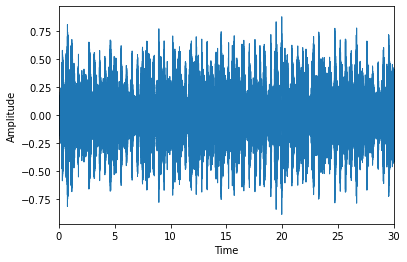

In [18]:
librosa.display.waveplot(signal, sr=sr)
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.show()

### Frequency Domain (Fast Fourier Transform)

In [7]:
fft = np.fft.fft(signal)

magnitude = np.abs(fft) # indication of contribution of each frequency to the overall sound
frequency = np.linspace(0, sr, len(magnitude)) #gives a number of evenly spaced numbers in an interval. 
# Frequency interval is here 0 HZ and sample rate. Number of evenly paced values we want which is the length of magnitude


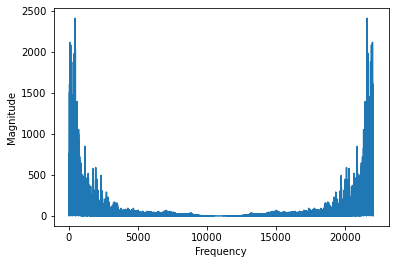

In [20]:
plt.plot(frequency, magnitude)
plt.xlabel("Frequency")
plt.ylabel("Magnitude")
plt.show()

### Interpretation
The first half of this is what brings us the novelty, the second half is the same information with the first half. Let's handle it by dividing it by two. 

In [21]:
left_frequency = frequency[:int(len(frequency)/2)]
left_magnitude = magnitude[:int(len(magnitude)/2)]

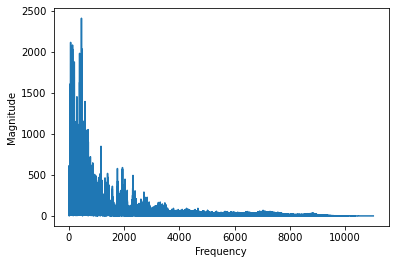

In [22]:
plt.plot(left_frequency, left_magnitude)
plt.xlabel("Frequency")
plt.ylabel("Magnitude")
plt.show()

In [23]:
#@title
#number of samples per fft  (number of samples, window we're considering for performing a single fft)
n_fft = 2048
#amount we're shifting each fourier transform to the right. When we doSTFT we slide an interval, 
#each interval we calculate a fft and hop_length will tell us how much we're shifting
hop_length = 512


In [26]:
stft = librosa.core.stft(signal, hop_length = hop_length, n_fft = n_fft)
spectogram = np.abs(stft)

In [25]:
log_spectogram = librosa.amplitude_to_db(spectogram)

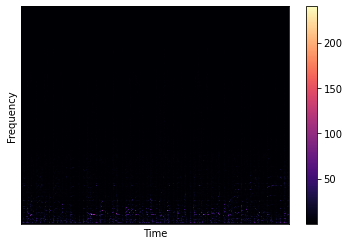

In [27]:
librosa.display.specshow(spectogram, sr=sr, hop_length=hop_length)
plt.xlabel("Time")
plt.ylabel("Frequency")
plt.colorbar()
plt.show()

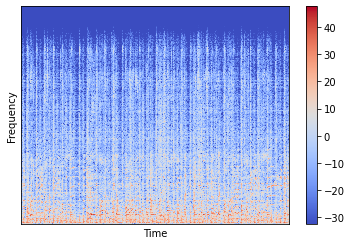

In [28]:
librosa.display.specshow(log_spectogram, sr=sr, hop_length=hop_length)
plt.xlabel("Time")
plt.ylabel("Frequency")
plt.colorbar()
plt.show()

### MFFCs (Mel Frequency Cepstral Coefficients)

In [ ]:
MFFCs = librosa.feature.mfcc(signal, n_fft=n_fft, hop_length=hop_length, n_mfcc=13)
librosa.display.specshow(MFFCs, sr=sr, hop_length=hop_length)
plt.xlabel("Time")
plt.ylabel("MFFC")
plt.colorbar()
plt.show()

In [ ]:
# TESTING

# file_path = '/Users/ilyaskarimov/Documents/GitHub/ADA-GW-Fall2020-IlyasKarimov-/Music_Genre_Classification/Data/genres_original_copy/blues/blues.00000.wav'

# data = {
#         "mapping": [],
#         "mfcc": [],
#         "labels": []
#     }

# num_samples_per_segment = int(SAMPLES_PER_TRACK / num_segments) # 22050 * 30 / 10  
# num_mfcc = 13
# expected_num_mfcc_vectors_per_segment = math.ceil(num_samples_per_segment/hop_length) # # (22050 * 30) / (10 * 512 )


# signal, sr = librosa.load(file_path, sr=SAMPLE_RATE)
# num_segments = 1

# # process segments extracting mfcc and storing data 
# for s in range(num_segments):
#     start_sample = num_samples_per_segment * s #s=0 -> 0
#     finish_sample = start_sample + num_samples_per_segment #s=0 -> num_samples_per_segment

#     mfcc = librosa.feature.mfcc(signal[start_sample:finish_sample], sr, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)

#     mfcc = mfcc.T

#     # store mfcc for segment if it has the expected length 
#     if len(mfcc) == expected_num_mfcc_vectors_per_segment:
#         data["mfcc"].append(mfcc.tolist())
#         data["labels"].append(0)
#         print("{}, segment:{}".format(file_path, s+1))
        

        
# JSON_PATH = "data3.json"
# with open(JSON_PATH, "w") as fp:
#         json.dump(data,fp, indent=4)


In [ ]:
if __name__ == "__main__":
    save_as_mfcc(TH_DATASET_PATH, JSON_PATH, num_segments=30)

# Music Genre Multi-classification with Neural Network 
The steps are as the followings: 
- Load the data 
- Split the data into train, validation and test sets 
- Building neural network 
- Compiling 
- Training 
- Testing

In [ ]:
print(JSON_PATH)

### Load Data

In [ ]:
with open(JSON_PATH, "r") as fp:
    data = json.load(fp)
    print(data)

inputs = np.array(data["mfcc"])
targets = np.array(data["labels"])

### Splitting Data to train and test

In [ ]:
X_train, X_test, y_train, y_test =  train_test_split(inputs, targets, test_size=0.2)

### Building NN

In [ ]:
# inputs is 3D: index, intervals and MFCC values, therefore, inputs[1] - intervals , inputps[2] - values of MFCCs

model = keras.Sequential([
    keras.layers.Flatten(input_shape = (inputs.shape[1], inputs.shape[2])),
    
    #1st hidden layer 
#     keras.layers.Dense(512, activation = "relu",  name="layer1"), 
    
    #2nd hidden layer 
    keras.layers.Dense(256, activation = "relu",  name="layer2"), 
    
    #3nd hidden layer 
    keras.layers.Dense(64, activation = "relu",  name="layer3"), 
    
    #output layer 
    keras.layers.Dense(10, activation = "softmax",  name="outputlayer") # labels. (Softmax is for multiclasss, sigmoid for binary classification)
])


### Compiling 

In [ ]:
optimizer = keras.optimizers.Adam(learning_rate=0.0002)
model.compile(optimizer=optimizer, 
              loss = "sparse_categorical_crossentropy", 
              metrics = ["accuracy"]
)
model.summary()

In [ ]:
#@title
print(len(model.layers)) 

### Train network

In [ ]:
history = model.fit(X_train, y_train, 
          validation_data=(X_test, y_test), 
          epochs=150, 
          batch_size=32)

In [ ]:
history = model.fit(X_train, y_train, 
          validation_data=(X_test, y_test), 
          epochs=50, 
          batch_size=32)

### Overfitting... 

### Plotting

In [ ]:
plt.plot(history.history["accuracy"], label="train accuracy")
plt.plot(history.history["val_accuracy"], label="test accuracy")
plt.ylabel("Accuracy")
plt.legend(loc="lower right")    
plt.show()

In [ ]:
plt.plot(history.history["accuracy"], label="train accuracy")
plt.plot(history.history["val_accuracy"], label="test accuracy")
plt.ylabel("Accuracy")
plt.legend(loc="lower right")    
plt.show()

# Convolutional Neural Network

In [ ]:
len(inputs)

In [ ]:
inputs.shape

In [ ]:
X_train, X_test, y_train, y_test =  train_test_split(inputs, targets, test_size=0.3)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5)

In [ ]:
print(X_train[0][0][0])

In [ ]:

X_train.shape

In [ ]:

# add an axis to input sets
X_train = X_train[..., np.newaxis]
X_val = X_val[..., np.newaxis]
X_test = X_test[..., np.newaxis]

In [ ]:
input_shape = (X_train.shape[1], X_train.shape[2], 1) ##

In [ ]:
print(input_shape)

In [ ]:
model_cnn = keras.Sequential()

# st conv layer
model_cnn.add(keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
model_cnn.add(keras.layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same'))
model_cnn.add(keras.layers.BatchNormalization())

# 2nd conv layer
model_cnn.add(keras.layers.Conv2D(32, (3, 3), activation='relu'))
model_cnn.add(keras.layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same'))
model_cnn.add(keras.layers.BatchNormalization())

# 3rd conv layer
model_cnn.add(keras.layers.Conv2D(32, (2, 2), activation='relu'))
model_cnn.add(keras.layers.MaxPooling2D((2, 2), strides=(2, 2), padding='same'))
model_cnn.add(keras.layers.BatchNormalization())

# flatten output and feed it into dense layer
model_cnn.add(keras.layers.Flatten())
model_cnn.add(keras.layers.Dense(64, activation='relu'))
model_cnn.add(keras.layers.Dropout(0.3))

# output layer
model_cnn.add(keras.layers.Dense(10, activation='softmax'))


In [ ]:
# compile model
optimiser = keras.optimizers.Adam(learning_rate=0.0001)
model_cnn.compile(optimizer=optimiser,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model_cnn.summary()

In [ ]:

history = model_cnn.fit(X_train, y_train, validation_data=(X_val, y_val), batch_size=32, epochs=60)

In [ ]:
# evaluate model on test set
test_loss, test_acc = model_cnn.evaluate(X_test, y_test, verbose=2)
print('\nTest accuracy:', test_acc)

In [ ]:
len(X_test)

In [ ]:
# pick a sample to predict from the test set
X_to_predict = X_test[100]
y_to_predict = y_test[100]

In [ ]:
X_to_predict.shape

In [ ]:
X_to_predict = X_to_predict[np.newaxis, ...] # array shape (1, 130, 13, 1)

In [ ]:

# perform prediction
# print(X_to_predict)
prediction = model_cnn.predict(X_to_predict)
# print(prediction)
# get index with max value
predicted_index = np.argmax(prediction, axis=1)

print("Target: {}, Predicted label: {}".format(y_to_predict, predicted_index))

### Plot accuracy/error for training and validation

In [ ]:
plot_accuracy(history)

In [ ]:
#@title
plot_loss(history)

## Preparation of mugam data

In [ ]:
# Specify the path of newly added songs and where to store them as .wav
new_songs_path = "/Users/ilyaskarimov/Documents/GitHub/ADA-GW-Fall2020-IlyasKarimov-/Music_Genre_Classification/Data/mugam_original"
wav_songs_path = "/Users/ilyaskarimov/Documents/GitHub/ADA-GW-Fall2020-IlyasKarimov-/Music_Genre_Classification/Data/genres+mugam/mugam"

In [ ]:
# Find those song files
onlyfiles = [f for f in listdir(new_songs_path) if isfile(join(new_songs_path, f))]

In [ ]:
print(onlyfiles)

In [ ]:
numb = 0
audio_length = 30 * 1000 # in milliseconds, 30 seconds
for f in onlyfiles: 
    filename = os.fsdecode(f)
    if filename.endswith(".mp3"):
        xpath = os.path.join(new_songs_path,filename)
        print(xpath)
        new  = os.path.join(os.path.join(wav_songs_path),"mugam."+ str(numb).zfill(5) + ".wav" )
        audSeg = AudioSegment.from_mp3(xpath)
        audSeg = audSeg[0:audio_length]
        audSeg = audSeg.set_frame_rate(22050)
        audSeg.export(new, format="wav")
        numb = numb +  1

## Writing MFCC to json with genre mugam

In [ ]:
NEW_DATASET_PATH = "./Data/genres+mugam"
NEW_JSON_PATH = "new_data.json"
onesegment_NEW_JSON_PATH = "onesegment_new_data.json"
SAMPLE_RATE = 22050
DURATION = 30 #in seconds
SAMPLES_PER_TRACK = SAMPLE_RATE*DURATION #22050*30

In [ ]:
save_mfcc(NEW_DATASET_PATH, NEJSON_PATH, num_segments=10)

## CNN with Mugam data

In [ ]:
save_mfcc(DATASET_PATH, onesegment_NEW_JSON_PATH, num_segments=1)

In [ ]:
NEW_DATASET_PATH = "./Data/genres+mugam"
NEW_JSON_PATH = "new_data.json"

In [ ]:
with open(NEW_JSON_PATH, "r") as fp:
    new_data = json.load(fp)

In [ ]:
new_inputs = np.array(new_data["mfcc"])
new_targets = np.array(new_data["labels"])

In [ ]:
len(new_targets)

In [ ]:
new_inputs.shape

In [ ]:
len(new_inputs)

In [ ]:
new_X_train, new_X_test, new_y_train, new_y_test =  train_test_split(new_inputs, new_targets, test_size=0.3)
new_X_test, new_X_val, new_y_test, new_y_val = train_test_split(new_X_test, new_y_test, test_size=0.5)

In [ ]:
# add an axis to input sets
new_X_train = new_X_train[..., np.newaxis]
new_X_val = new_X_val[..., np.newaxis]
new_X_test = new_X_test[..., np.newaxis]

In [ ]:
new_input_shape = (new_X_train.shape[1], new_X_train.shape[2], 1) ##

In [ ]:
new_model_cnn_2 = keras.Sequential()

# st conv layer
new_model_cnn_2.add(keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=new_input_shape))
new_model_cnn_2.add(keras.layers.MaxPooling2D((2, 2), strides=(1, 1), padding='same'))
new_model_cnn_2.add(keras.layers.BatchNormalization())

# 2nd conv layer
new_model_cnn_2.add(keras.layers.Conv2D(32, (3, 3), activation='relu'))
new_model_cnn_2.add(keras.layers.MaxPooling2D((2, 2), strides=(1, 1), padding='same'))
new_model_cnn_2.add(keras.layers.BatchNormalization())

# flatten output and feed it into dense layer
new_model_cnn_2.add(keras.layers.Flatten())
new_model_cnn_2.add(keras.layers.Dense(64, activation='relu'))
new_model_cnn_2.add(keras.layers.Dropout(0.3))

# output layer
new_model_cnn_2.add(keras.layers.Dense(11, activation='softmax'))

In [ ]:
new_model_cnn = keras.Sequential()

# st conv layer
new_model_cnn.add(keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=new_input_shape))
new_model_cnn.add(keras.layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same'))
new_model_cnn.add(keras.layers.BatchNormalization())

# 2nd conv layer
new_model_cnn.add(keras.layers.Conv2D(32, (3, 3), activation='relu'))
new_model_cnn.add(keras.layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same'))
new_model_cnn.add(keras.layers.BatchNormalization())

# 3rd conv layer
new_model_cnn.add(keras.layers.Conv2D(32, (2, 2), activation='relu'))
new_model_cnn.add(keras.layers.MaxPooling2D((2, 2), strides=(2, 2), padding='same'))
new_model_cnn.add(keras.layers.BatchNormalization())

# flatten output and feed it into dense layer
new_model_cnn.add(keras.layers.Flatten())
new_model_cnn.add(keras.layers.Dense(64, activation='relu'))
new_model_cnn.add(keras.layers.Dropout(0.3))

# output layer
new_model_cnn.add(keras.layers.Dense(11, activation='softmax'))


In [ ]:
# compile model
optimiser = keras.optimizers.Adam(learning_rate=0.0001)
new_model_cnn.compile(optimizer=optimiser,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

new_model_cnn.summary()

In [ ]:
new_history = new_model_cnn.fit(new_X_train, new_y_train, validation_data=(new_X_val, new_y_val), batch_size=32, epochs=60)

In [ ]:
plot_accuracy(new_history)

In [ ]:
plot_loss(new_history)

In [ ]:
# evaluate model on test set
new_test_loss, new_test_acc = new_model_cnn.evaluate(new_X_test, new_y_test, verbose=2)
print('\nTest accuracy:', new_test_acc)

In [ ]:
# pick a sample to predict from the test set
new_X_to_predict = new_X_test[100]
new_y_to_predict = new_y_test[100]

In [ ]:
new_X_to_predict.shape

In [ ]:
new_X_to_predict = new_X_to_predict[np.newaxis, ...] # array shape (1, 130, 13, 1)

In [ ]:
# perform prediction
# print(X_to_predict)
new_prediction = new_model_cnn.predict(new_X_to_predict)
# print(prediction)
# get index with max value
new_predicted_index = np.argmax(new_prediction, axis=1)

print("Target: {}, Predicted label: {}".format(new_y_to_predict, new_predicted_index))

## CNN with 1 segment size 

In [ ]:
onesegment_NEW_JSON_PATH = "onesegment_new_data.json"

In [ ]:
with open(onesegment_NEW_JSON_PATH, "r") as fp:
    seg1_new_data = json.load(fp) 

In [ ]:
seg1_inputs = np.array(seg1_new_data["mfcc"])
seg1_targets = np.array(seg1_new_data["labels"])

seg1_inputs.shape

In [ ]:
seg1_X_train, seg1_X_test, seg1_y_train, seg1_y_test =  train_test_split(seg1_inputs, seg1_targets, test_size=0.3)
seg1_X_test, seg1_X_val, seg1_y_test, seg1_y_val = train_test_split(seg1_X_test, seg1_y_test, test_size=0.5)

In [ ]:
seg1_X_train = seg1_X_train[..., np.newaxis]
seg1_X_val = seg1_X_val[..., np.newaxis]
seg1_X_test = seg1_X_test[..., np.newaxis]

In [ ]:
seg1_inputs_shape = (seg1_X_train.shape[1], seg1_X_train.shape[2], 1) ##

In [ ]:
seg1_model_cnn = keras.Sequential()

In [ ]:
# st conv layer
seg1_model_cnn.add(keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=seg1_inputs_shape))
seg1_model_cnn.add(keras.layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same'))
seg1_model_cnn.add(keras.layers.BatchNormalization())

# 2nd conv layer
seg1_model_cnn.add(keras.layers.Conv2D(32, (3, 3), activation='relu'))
seg1_model_cnn.add(keras.layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same'))
seg1_model_cnn.add(keras.layers.BatchNormalization())

# 3rd conv layer
seg1_model_cnn.add(keras.layers.Conv2D(32, (2, 2), activation='relu'))
seg1_model_cnn.add(keras.layers.MaxPooling2D((2, 2), strides=(2, 2), padding='same'))
seg1_model_cnn.add(keras.layers.BatchNormalization())

# flatten output and feed it into dense layer
seg1_model_cnn.add(keras.layers.Flatten())
seg1_model_cnn.add(keras.layers.Dense(64, activation='relu'))
seg1_model_cnn.add(keras.layers.Dropout(0.3))

# output layer
seg1_model_cnn.add(keras.layers.Dense(11, activation='softmax'))


In [ ]:
# compile model
optimiser = keras.optimizers.Adam(learning_rate=0.0001)
seg1_model_cnn.compile(optimizer=optimiser,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

seg1_model_cnn.summary()

In [ ]:
segone_history = seg1_model_cnn.fit(seg1_X_train, seg1_y_train, validation_data=(seg1_X_val, seg1_y_val), batch_size=32, epochs=60)

In [ ]:
plot_accuracy(segone_history)

In [ ]:
plot_loss(segone_history)

In [ ]:
# evaluate model on test set
seg1_test_loss, seg1_test_acc = seg1_model_cnn.evaluate(seg1_X_test, seg1_y_test, verbose=2)
print('\nTest accuracy:', seg1_test_acc)

In [ ]:
# pick a sample to predict from the test set
seg1_X_to_predict = seg1_X_test[100]
seg1_y_to_predict = seg1_y_test[100]

In [ ]:
seg1_X_to_predict.shape

In [ ]:
seg1_X_to_predict = seg1_X_to_predict[np.newaxis, ...] # array shape (1, 130, 13, 1)

In [ ]:
# perform prediction
# print(X_to_predict)
seg1_prediction = seg1_model_cnn.predict(seg1_X_to_predict)
# print(prediction)
# get index with max value
seg1_predicted_index = np.argmax(seg1_prediction, axis=1)

print("Target: {}, Predicted label: {}".format(seg1_y_to_predict, seg1_predicted_index))

## RNN-LSTM 

In [ ]:
lstm_model = keras.Sequential()

In [ ]:
smaller_lstm_model = keras.Sequential()

In [ ]:
lstm_input_shape = (new_X_train.shape[1], new_X_train.shape[2]) ##

In [ ]:
lstm_model.add(keras.layers.LSTM(64, input_shape=lstm_input_shape, return_sequences=True))
lstm_model.add(keras.layers.LSTM(64))

# dense layer
lstm_model.add(keras.layers.Dense(64, activation='relu'))
lstm_model.add(keras.layers.Dropout(0.3))

# output layer
lstm_model.add(keras.layers.Dense(11, activation='softmax'))

In [ ]:
smaller_lstm_model.add(keras.layers.LSTM(32, input_shape=lstm_input_shape, return_sequences=True))
smaller_lstm_model.add(keras.layers.LSTM(32))

# dense layer
smaller_lstm_model.add(keras.layers.Dense(32, activation='relu'))
lstm_model.add(keras.layers.Dropout(0.3))

# output layer
smaller_lstm_model.add(keras.layers.Dense(11, activation='softmax'))

In [ ]:
optimiser = keras.optimizers.Adam(learning_rate=0.0001)
lstm_model.compile(optimizer=optimiser,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

lstm_model.summary()

In [ ]:
optimiser = keras.optimizers.Adam(learning_rate=0.0001)
smaller_lstm_model.compile(optimizer=optimiser,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

smaller_lstm_model.summary()

In [ ]:
lstm_history = lstm_model.fit(new_X_train, new_y_train, validation_data=(new_X_val, new_y_val), batch_size=32, epochs=60)

In [ ]:
v2_lstm_history = lstm_model.fit(new_X_train, new_y_train, validation_data=(new_X_val, new_y_val), batch_size=32, epochs=150)

In [ ]:
smaller_lstm_history = smaller_lstm_model.fit(new_X_train, new_y_train, validation_data=(new_X_val, new_y_val), batch_size=32, epochs=75)

In [ ]:
smaller_lstm_history = smaller_lstm_model.fit(new_X_train, new_y_train, validation_data=(new_X_val, new_y_val), batch_size=32, epochs=75)

In [ ]:
plot_accuracy(v2_lstm_history)

In [ ]:
plot_loss(v2_lstm_history)

In [ ]:
plot_accuracy(smaller_lstm_history)

In [ ]:
plot_loss(smaller_lstm_history)

In [ ]:
# evaluate model on test set
lstm_test_loss, lstm_test_acc = lstm_model_cnn.evaluate(new_X_test, new_y_test, verbose=2)
print('\nTest accuracy:', lstm_test_acc)

In [ ]:
# pick a sample to predict from the test set
new_X_to_predict = new_X_test[100]
new_y_to_predict = new_y_test[100]

In [ ]:
new_X_to_predict.shape

In [ ]:
new_X_to_predict = new_X_to_predict[np.newaxis, ...] # array shape (1, 130, 13, 1)

In [ ]:
# perform prediction
# print(X_to_predict)
new_prediction = lstm_model_cnn.predict(new_X_to_predict)
# print(prediction)
# get index with max value
new_predicted_index = np.argmax(new_prediction, axis=1)

print("Target: {}, Predicted label: {}".format(new_y_to_predict, new_predicted_index))

## Extracting new  music/songs

## Classical

In [ ]:
# Specify the path of newly added songs and where to store them as .wav
read_path_classic = "/Users/ilyaskarimov/Documents/GitHub/ADA-GW-Fall2020-IlyasKarimov-/Music_Genre_Classification/New_100_Songs/Classical"
write_path_classic = "/Users/ilyaskarimov/Documents/GitHub/ADA-GW-Fall2020-IlyasKarimov-/Music_Genre_Classification/Updated_data_09.03.2022/classical"

In [ ]:
write_as_wav(read_path_classic, write_path_classic, "classical.")

## Rock 

In [ ]:
# Specify the path of newly added songs and where to store them as .wav
read_path_rock = "/Users/ilyaskarimov/Documents/GitHub/ADA-GW-Fall2020-IlyasKarimov-/Music_Genre_Classification/New_100_Songs/Rock"
write_path_rock = "/Users/ilyaskarimov/Documents/GitHub/ADA-GW-Fall2020-IlyasKarimov-/Music_Genre_Classification/Updated_data_09.03.2022/rock"

In [ ]:
write_as_wav(read_path_rock, write_path_rock, "rock.")

## Blues

In [ ]:
# Specify the path of newly added songs and where to store them as .wav
read_path_blues = "/Users/ilyaskarimov/Documents/GitHub/ADA-GW-Fall2020-IlyasKarimov-/Music_Genre_Classification/New_100_Songs/Blues"
write_path_blues = "/Users/ilyaskarimov/Documents/GitHub/ADA-GW-Fall2020-IlyasKarimov-/Music_Genre_Classification/Updated_data_09.03.2022/blues"

In [ ]:
write_as_wav(read_path_blues, write_path_blues, "blues.")

## Reggae

In [ ]:
# Specify the path of newly added songs and where to store them as .wav
read_path_reggae = "/Users/ilyaskarimov/Documents/GitHub/ADA-GW-Fall2020-IlyasKarimov-/Music_Genre_Classification/New_100_Songs/Reggae"
write_path_reggae = "/Users/ilyaskarimov/Documents/GitHub/ADA-GW-Fall2020-IlyasKarimov-/Music_Genre_Classification/Updated_data_09.03.2022/reggae"

In [ ]:
write_as_wav(read_path_reggae, write_path_reggae, "reggae.")

## Country

In [ ]:
#@title
# Specify the path of newly added songs and where to store them as .wav
read_path_country = "/Users/ilyaskarimov/Documents/GitHub/ADA-GW-Fall2020-IlyasKarimov-/Music_Genre_Classification/New_100_Songs/Country"
write_path_country = "/Users/ilyaskarimov/Documents/GitHub/ADA-GW-Fall2020-IlyasKarimov-/Music_Genre_Classification/Updated_data_09.03.2022/country"

In [ ]:
#@title
write_as_wav(read_path_country, write_path_country, "country.")

## Disco

In [ ]:
#@title
# Specify the path of newly added songs and where to store them as .wav
read_path_disco = "/Users/ilyaskarimov/Documents/GitHub/ADA-GW-Fall2020-IlyasKarimov-/Music_Genre_Classification/New_100_Songs/Disco"
write_path_disco = "/Users/ilyaskarimov/Documents/GitHub/ADA-GW-Fall2020-IlyasKarimov-/Music_Genre_Classification/Updated_data_09.03.2022/disco"

In [ ]:
#@title
write_as_wav(read_path_disco, write_path_disco, "disco.")

## Hiphop

In [ ]:
#@title
# Specify the path of newly added songs and where to store them as .wav
read_path_hiphop = "/Users/ilyaskarimov/Documents/GitHub/ADA-GW-Fall2020-IlyasKarimov-/Music_Genre_Classification/New_100_Songs/HipHop"
write_path_hiphop = "/Users/ilyaskarimov/Documents/GitHub/ADA-GW-Fall2020-IlyasKarimov-/Music_Genre_Classification/Updated_data_09.03.2022/hiphop"

In [ ]:
#@title
write_as_wav(read_path_hiphop, write_path_hiphop, "hiphop.")

## Jazz

In [ ]:
#@title
# Specify the path of newly added songs and where to store them as .wav
read_path_jazz = "/Users/ilyaskarimov/Documents/GitHub/ADA-GW-Fall2020-IlyasKarimov-/Music_Genre_Classification/New_100_Songs/Jazz"
write_path_jazz = "/Users/ilyaskarimov/Documents/GitHub/ADA-GW-Fall2020-IlyasKarimov-/Music_Genre_Classification/Updated_data_09.03.2022/jazz"

In [ ]:
#@title
write_as_wav(read_path_jazz, write_path_jazz, "jazz.")

## Pop

In [ ]:
#@title
# Specify the path of newly added songs and where to store them as .wav
read_path_pop = "/Users/ilyaskarimov/Documents/GitHub/ADA-GW-Fall2020-IlyasKarimov-/Music_Genre_Classification/New_100_Songs/Pop"
write_path_pop = "/Users/ilyaskarimov/Documents/GitHub/ADA-GW-Fall2020-IlyasKarimov-/Music_Genre_Classification/Updated_data_09.03.2022/pop"   

In [ ]:
#@title
write_as_wav(read_path_pop, write_path_pop, "pop.")

## Metal

In [ ]:
# Specify the path of newly added songs and where to store them as .wav
read_path_metal = "/Users/ilyaskarimov/Documents/GitHub/ADA-GW-Fall2020-IlyasKarimov-/Music_Genre_Classification/New_100_Songs/Metal"
write_path_metal = "/Users/ilyaskarimov/Documents/GitHub/ADA-GW-Fall2020-IlyasKarimov-/Music_Genre_Classification/Updated_data_09.03.2022/metal"

In [ ]:
write_as_wav(read_path_metal, write_path_metal, "metal.")

In [ ]:
TH_DATASET_PATH = "./Updated_data_09.03.2022"
TH_NEW_JSON_PATH = "/content/drive/MyDrive/Music_Genre_Classification/th_data.json"
SAMPLE_RATE = 22050
DURATION = 30 #in seconds
SAMPLES_PER_TRACK = SAMPLE_RATE*DURATION #22050*30

In [ ]:
save_mfcc(TH_DATASET_PATH, TH_NEW_JSON_PATH, num_segments=10)

## CNN with 200 new data

In [ ]:
conv1d_data["mfcc"]

In [ ]:
th_inputs.shape

CNN with old data

In [ ]:
th_targets.shape

In [ ]:
|th_X_train, th_X_test, th_y_train, th_y_test =  train_test_split(th_inputs, th_targets, test_size=0.2)
# th_X_test, th_X_val, th_y_test, th_y_val = train_test_split(th_X_test, th_y_test, test_size=0.5)

th_X_train.shape

In [ ]:
# add an axis to input sets
th_X_train = th_X_train[..., np.newaxis]
# th_X_val = th_X_val[..., np.newaxis]
th_X_test = th_X_test[..., np.newaxis]

In [ ]:
th_input_shape = (th_X_train.shape[1], th_X_train.shape[2], 1) ##

print(th_input_shape)

In [ ]:
th_model_cnn = keras.Sequential()

# st conv layer
th_model_cnn.add(keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=th_input_shape))
th_model_cnn.add(keras.layers.MaxPooling2D((3, 3), strides=(2, 2) , padding='same'))
th_model_cnn.add(keras.layers.BatchNormalization())

# 2nd conv layer
th_model_cnn.add(keras.layers.Conv2D(32, (3, 3), activation='relu'))
th_model_cnn.add(keras.layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same'))
th_model_cnn.add(keras.layers.BatchNormalization())

# 3rd conv layer
th_model_cnn.add(keras.layers.Conv2D(32, (2, 2), activation='relu'))
th_model_cnn.add(keras.layers.MaxPooling2D((2, 2), strides=(2, 2), padding='same'))
th_model_cnn.add(keras.layers.BatchNormalization())

# flatten output and feed it into dense layer
th_model_cnn.add(keras.layers.Flatten())
th_model_cnn.add(keras.layers.Dense(64, activation='relu'))
th_model_cnn.add(keras.layers.Dropout(0.3))

# output layer
th_model_cnn.add(keras.layers.Dense(11, activation='softmax'))

In [ ]:
# compile model
optimiser = keras.optimizers.Adam(learning_rate=0.0001)
th_model_cnn.compile(optimizer=optimiser,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

th_model_cnn.summary()

In [ ]:
th_history = th_model_cnn.fit(th_X_train, th_y_train, validation_data=(th_X_test, th_y_test), batch_size=32, epochs=60)

In [ ]:
th_history = th_model_cnn.fit(th_X_train, th_y_train, validation_data=(th_X_test, th_y_test), batch_size=32, epochs=30)

In [ ]:
th_history = th_model_cnn.fit(th_X_train, th_y_train, validation_data=(th_X_test, th_y_test), batch_size=32, epochs=30)

In [ ]:
plot_accuracy(th_history)

In [ ]:
plot_loss(th_history)

## Continuation

In [ ]:
th_history = th_model_cnn.fit(th_X_train, th_y_train, validation_data=(th_X_val, th_y_val), batch_size=32, epochs=60)

## RNN-LSTM

In [ ]:
th_lstm_model = keras.Sequential()

In [ ]:
th_input_shape = (conv1d_X_train.shape[1], conv1d_X_train.shape[2]) ##

In [ ]:
th_lstm_model.add(keras.layers.LSTM(64, input_shape=th_input_shape, return_sequences=True))
th_lstm_model.add(keras.layers.LSTM(64))

# dense layer
th_lstm_model.add(keras.layers.Dense(64, activation='relu'))
th_lstm_model.add(keras.layers.Dropout(0.3))

# output layer
th_lstm_model.add(keras.layers.Dense(11, activation='softmax'))

optimiser = keras.optimizers.Adam(learning_rate=0.01)
th_lstm_model.compile(optimizer=optimiser,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

th_lstm_model.summary()

In [ ]:
th_lstm_history = th_lstm_model.fit(conv1d_X_train, conv1d_y_train, validation_data=(conv1d_X_val, conv1d_y_val), batch_size=32, epochs=60)

In [ ]:
plot_accuracy(th_lstm_history)

In [ ]:
plot_loss(th_lstm_history)

## New CNN with one dimensional convolutional layer.

In [ ]:
from tensorflow.keras.utils import to_categorical
import json

In [ ]:
'''data_dir = "/content/drive/MyDrive/Data's/Songs classifier/mfcc_200_songs_15.json"

with open(data_dir, "r") as fp:
    conv1d_data = json.load(fp)'''

In [ ]:
with open(TH_NEW_JSON_PATH, "r") as fp:
    conv1d_data = json.load(fp)

In [ ]:
conv1d_inputs = np.array(next_inputs["mfcc"])
conv1d_targets = np.array(next_inputs["labels"])

In [ ]:
th_X_train, th_X_test, th_y_train, th_y_test =  train_test_split(next_inputs, next_targets, test_size=0.4,  shuffle = True)
th_X_test, th_X_val, th_y_test, th_y_val = train_test_split(th_X_test, th_y_test, test_size=0.5, shuffle = True)

th_X_train.shape

# add an axis to input sets
#conv1d_X_train = conv1d_X_train[..., np.newaxis]
#conv1d_X_val = conv1d_X_val[..., np.newaxis]
#conv1d_X_test = conv1d_X_test[..., np.newaxis]

conv1d_input_shape = (th_X_train.shape[1], th_X_train.shape[2], 1) ##

print(conv1d_input_shape)

In [ ]:
th_y_train = to_categorical(th_y_train, 11)
th_y_val = to_categorical(th_y_val, 11)
th_y_test = to_categorical(th_y_test, 11)

In [ ]:
DROPOUT_RATE = 0.
CONV_DROPOUT_RATE = 0.2

In [ ]:
from keras.layers.convolutional import Conv1D
from keras.models import Sequential
from keras.layers import Conv1D, Dense, MaxPooling1D, Flatten, Input


In [ ]:
conv1d_input_shape

In [ ]:
# Create conv1d_model
conv1d_model =  keras.Sequential()

# First block
conv1d_model.add(Conv1D(filters=16,
                 kernel_size=3,
                 input_shape=(87,13),
                 activation='relu',
                 padding='same'))

conv1d_model.add(Conv1D(filters=16,
                 kernel_size=3,
                 activation='relu',
                 padding='same'))

conv1d_model.add(keras.layers.MaxPooling1D(pool_size=2, strides=1, padding='same'))
conv1d_model.add(keras.layers.Dropout(CONV_DROPOUT_RATE))

# Second block
conv1d_model.add(Conv1D(filters=32,
                 kernel_size=3,
                 activation='relu',
                 padding='same'))

conv1d_model.add(Conv1D(filters=32,
                 kernel_size=3,
                 activation='relu',
                 padding='same'))

conv1d_model.add(keras.layers.MaxPooling1D(pool_size=2,   strides=1, padding='same'))
conv1d_model.add(keras.layers.Dropout(CONV_DROPOUT_RATE))

# Third block
conv1d_model.add(Conv1D(filters=64,
                 kernel_size=3,
                 activation='relu',
                 padding='same'))

conv1d_model.add(Conv1D(filters=64,
                 kernel_size=3,
                 activation='relu',
                 padding='same'))

conv1d_model.add(keras.layers.MaxPooling1D(pool_size=2,   strides=1, padding='same'))
conv1d_model.add(keras.layers.Dropout(CONV_DROPOUT_RATE))


# Fully connected layers
conv1d_model.add(Flatten())
conv1d_model.add(Dense(512, activation='relu'))
conv1d_model.add(Dense(512, activation='relu'))
conv1d_model.add(keras.layers.Dropout(CONV_DROPOUT_RATE))
# Output
conv1d_model.add(Dense(11, activation='softmax'),)

In [ ]:
conv1d_model.compile(loss="categorical_crossentropy",
                      optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                      metrics=["accuracy"])

In [ ]:
conv1d_model.summary()

In [ ]:
conv1d_history = conv1d_model.fit(th_X_train, th_y_train, validation_data=(th_X_val, th_y_val), batch_size=32, epochs=100)

In [ ]:
conv1d_history = conv1d_model.fit(x = conv1d_X_train,
                                  y = conv1d_y_train,
                                  batch_size = 32,
                                  epochs = 5,
                                  validation_data = (conv1d_X_val, conv1d_y_val),
                                  steps_per_epoch = len(conv1d_X_train)//32,
                                  validation_steps = len(conv1d_X_val)//32)

Another model: 

In [ ]:
stride1_model_cnn = keras.Sequential()

# st conv layer
stride1_model_cnn.add(keras.layers.Conv2D(16, (3, 3), activation='relu', input_shape= next_inputs_shape))
stride1_model_cnn.add(keras.layers.MaxPooling2D((3, 3), strides=(1, 1), padding='same'))
stride1_model_cnn.add(keras.layers.BatchNormalization())

# 2nd conv layer
stride1_model_cnn.add(keras.layers.Conv2D(16, (3, 3), activation='relu'))
stride1_model_cnn.add(keras.layers.MaxPooling2D((3, 3), strides=(1, 1), padding='same'))
stride1_model_cnn.add(keras.layers.BatchNormalization())

# 3rd conv layer
stride1_model_cnn.add(keras.layers.Conv2D(16, (2, 2), activation='relu'))
stride1_model_cnn.add(keras.layers.MaxPooling2D((2, 2), strides=(1, 1), padding='same'))
stride1_model_cnn.add(keras.layers.BatchNormalization())

# flatten output and feed it into dense layer
stride1_model_cnn.add(keras.layers.Flatten())
stride1_model_cnn.add(keras.layers.Dense(32, activation='relu'))
stride1_model_cnn.add(keras.layers.Dropout(0.2))

# output layer
stride1_model_cnn.add(keras.layers.Dense(11, activation='softmax'))


In [ ]:
# compile model
optimiser = keras.optimizers.Adam(learning_rate=0.0005)
stride1_model_cnn.compile(optimizer=optimiser,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

stride1_model_cnn.summary()


In [ ]:
stride1_history = stride1_model_cnn.fit(th_X_train, th_y_train,  validation_data=(th_X_val, th_y_val), batch_size=32, epochs=80)

In [ ]:
stride_2_history = stide1_model_cnn.fit(th_X_train, th_y_train,  validation_data=(th_X_val, th_y_val), batch_size=32, epochs=90)

## CNN with new data

In [ ]:
th_X_train, th_X_test, th_y_train, th_y_test =  train_test_split(next_inputs, next_targets, test_size=0.2,  shuffle = True)
th_X_test, th_X_val, th_y_test, th_y_val = train_test_split(th_X_test, th_y_test, test_size=0.5, shuffle = True)

th_X_train.shape


In [ ]:
# add an axis to input sets
th_X_train = th_X_train[..., np.newaxis]
th_X_val = th_X_val[..., np.newaxis]
th_X_test = th_X_test[..., np.newaxis]

In [ ]:
next_inputs_shape = (th_X_train.shape[1], th_X_train.shape[2], 1) ##

print(next_inputs_shape)


In [ ]:
th_model_cnn_new_data = keras.Sequential()

# st conv layer
th_model_cnn_new_data.add(keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=next_inputs_shape))
th_model_cnn_new_data.add(keras.layers.MaxPooling2D((3, 3), strides=(2, 2) , padding='same'))
th_model_cnn_new_data.add(keras.layers.BatchNormalization())

# 2nd conv layer
th_model_cnn_new_data.add(keras.layers.Conv2D(32, (3, 3), activation='relu'))
th_model_cnn_new_data.add(keras.layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same'))
th_model_cnn_new_data.add(keras.layers.BatchNormalization())

# 3rd conv layer
th_model_cnn_new_data.add(keras.layers.Conv2D(32, (2, 2), activation='relu'))
th_model_cnn_new_data.add(keras.layers.MaxPooling2D((2, 2), strides=(2, 2), padding='same'))
th_model_cnn_new_data.add(keras.layers.BatchNormalization())

# flatten output and feed it into dense layer
th_model_cnn_new_data.add(keras.layers.Flatten())
th_model_cnn_new_data.add(keras.layers.Dense(64, activation='relu'))
th_model_cnn_new_data.add(keras.layers.Dropout(0.3))

# output layer
th_model_cnn_new_data.add(keras.layers.Dense(11, activation='softmax'))

In [ ]:
# compile model
optimiser = keras.optimizers.Adam()
th_model_cnn_new_data.compile(optimizer=optimiser,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

th_model_cnn_new_data.summary()

In [ ]:
th_history_new_data = th_model_cnn_new_data.fit(th_X_train, th_y_train, v validation_data=(th_X_val, th_y_val), batch_size=32, epochs=90)


In [ ]:
# compile model
optimiser = keras.optimizers.Adam(learning_rate=0.001)
th_model_cnn_new_data_2.compile(optimizer=optimiser,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

th_model_cnn_new_data_2.summary()

In [ ]:
th_history_new_data_2 = th_model_cnn_new_data_2.fit(th_X_train, th_y_train, validation_data=(th_X_val, th_y_val), batch_size=32, epochs=90)

In [ ]:
# With the same data but shuffled 
th_X_train, th_X_test, th_y_train, th_y_test =  train_test_split(next_inputs, next_targets, test_size=0.4,  shuffle = True)
th_X_test, th_X_val, th_y_test, th_y_val = train_test_split(th_X_test, th_y_test, test_size=0.5, shuffle = True)

th_X_train.shape

# add an axis to input sets
th_X_train = th_X_train[..., np.newaxis]
th_X_val = th_X_val[..., np.newaxis]
th_X_test = th_X_test[..., np.newaxis]


next_inputs_shape = (th_X_train.shape[1], th_X_train.shape[2], 1) ##

print(next_inputs_shape)

th_model_cnn_new_data_3 = keras.Sequential()

# st conv layer
th_model_cnn_new_data_3.add(keras.layers.Conv2D(16, (2, 2), activation='relu', input_shape=next_inputs_shape))
th_model_cnn_new_data_3.add(keras.layers.MaxPooling2D((2, 2), strides=(1, 1) , padding='same'))
th_model_cnn_new_data_3.add(keras.layers.BatchNormalization())

# 2nd conv layer
th_model_cnn_new_data_3.add(keras.layers.Conv2D(32, (3, 3), activation='relu'))
th_model_cnn_new_data_3.add(keras.layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same'))
th_model_cnn_new_data_3.add(keras.layers.BatchNormalization())

# 3rd conv layer
th_model_cnn_new_data_3.add(keras.layers.Conv2D(128, (2, 2), activation='relu'))
th_model_cnn_new_data_3.add(keras.layers.MaxPooling2D((2, 2), strides=(2, 2), padding='same'))
th_model_cnn_new_data_3.add(keras.layers.BatchNormalization())
th_model_cnn_new_data_3.add(keras.layers.Dropout(0.3))

th_model_cnn_new_data_3.add(keras.layers.Conv2D(128, (2, 2), activation='relu'))
th_model_cnn_new_data_3.add(keras.layers.MaxPooling2D((2, 2), strides=(2, 2), padding='same'))
th_model_cnn_new_data_3.add(keras.layers.BatchNormalization())
th_model_cnn_new_data_3.add(keras.layers.Dropout(0.3))

# flatten output and feed it into dense layer
th_model_cnn_new_data_3.add(keras.layers.Flatten())
th_model_cnn_new_data_3.add(keras.layers.Dense(256, activation='relu'))
th_model_cnn_new_data_3.add(keras.layers.Dropout(0.3))

# output layer
th_model_cnn_new_data_3.add(keras.layers.Dense(11, activation='softmax'))

# compile model
optimiser = keras.optimizers.Adam(learning_rate=0.001)
th_model_cnn_new_data_3.compile(optimizer=optimiser,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

th_model_cnn_new_data_3.summary()

th_history_new_data = th_model_cnn_new_data_3.fit(th_X_train, th_y_train,  validation_data=(th_X_val, th_y_val), batch_size=32, epochs=100)



learning rate = 0.0001, 60/20/20 
32, 32, 64, 64 
Epoch 90/90
574/574 [==============================] - 5s 9ms/step - loss: 0.5004 - accuracy: 0.8214 - val_loss: 1.2032 - val_accuracy: 0.6754

Epoch 60/60 ( her layer de 0.3 dropout, learning rate = 0.001, 60/20/20)
32, 32, 64, 64
574/574 [==============================] - 5s 8ms/step - loss: 1.0538 - 
accuracy: 0.6317 - val_loss: 0.9058 - val_accuracy: 0.6795
574/574 [==============================] - 5s 9ms/step - loss: 1.0277 - accuracy: 0.6436 - val_loss: 0.8922 - val_accuracy: 0.6909
Epoch 89/90
574/574 [==============================] - 5s 10ms/step - loss: 1.0019 - accuracy: 0.6514 - val_loss: 0.8376 - val_accuracy: 0.7110


32,32,64, 128  (64,128 de 0.3 dropout) 
learning rate = 0.001 
Epoch 150/150
574/574 [==============================] - 6s 10ms/step - loss: 0.4166 - accuracy: 0.8489 - val_loss: 0.9141 - val_accuracy: 0.7307


32, 32, 64, 128, 256 (128, 256 0.3 dropout), learning rate =0.001 
Epoch 60/60
574/574 [==============================] - 8s 13ms/step - loss: 0.3800 - accuracy: 0.8699 - val_loss: 0.8767 - val_accuracy: 0.7449



16,32,128, 128, 256  ( 128,128,256 de dropout 0.3)
learning rate = 0.001
Epoch 99/100
574/574 [==============================] - 7s 13ms/step - loss: 0.2376 - accuracy: 0.9186 - val_loss: 0.8373 - val_accuracy: 0.7661
Epoch 100/100
574/574 [==============================] - 8s 13ms/step - loss: 0.2197 - accuracy: 0.9266 - val_loss: 0.9017 - val_accuracy: 0.7522

In [ ]:
# With the same data but shuffled 
th_X_train, th_X_test, th_y_train, th_y_test =  train_test_split(next_inputs, next_targets, test_size=0.4,  shuffle = True)
th_X_test, th_X_val, th_y_test, th_y_val = train_test_split(th_X_test, th_y_test, test_size=0.5, shuffle = True)

th_X_train.shape

# add an axis to input sets
th_X_train = th_X_train[..., np.newaxis]
th_X_val = th_X_val[..., np.newaxis]
th_X_test = th_X_test[..., np.newaxis]


next_inputs_shape = (th_X_train.shape[1], th_X_train.shape[2], 1) ##

print(next_inputs_shape)

th_model_cnn_new_data_4 = keras.Sequential()

# st conv layer
th_model_cnn_new_data_4.add(keras.layers.Conv2D(256, (2, 2), activation='relu', input_shape=next_inputs_shape))
th_model_cnn_new_data_4.add(keras.layers.MaxPooling2D((2, 2), strides=(1, 1) , padding='same'))
th_model_cnn_new_data_4.add(keras.layers.BatchNormalization())

# 2nd conv layer
th_model_cnn_new_data_4.add(keras.layers.Conv2D(128, (3, 3), activation='relu'))
th_model_cnn_new_data_4.add(keras.layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same'))
th_model_cnn_new_data_4.add(keras.layers.BatchNormalization())

# 3rd conv layer
th_model_cnn_new_data_4.add(keras.layers.Conv2D(64, (2, 2), activation='relu'))
th_model_cnn_new_data_4.add(keras.layers.MaxPooling2D((2, 2), strides=(2, 2), padding='same'))
th_model_cnn_new_data_4.add(keras.layers.BatchNormalization())
th_model_cnn_new_data_4.add(keras.layers.Dropout(0.2))

th_model_cnn_new_data_4.add(keras.layers.Conv2D(32, (2, 2), activation='relu'))
th_model_cnn_new_data_4.add(keras.layers.MaxPooling2D((2, 2), strides=(2, 2), padding='same'))
th_model_cnn_new_data_4.add(keras.layers.BatchNormalization())
th_model_cnn_new_data_4.add(keras.layers.Dropout(0.2))

# flatten output and feed it into dense layer
th_model_cnn_new_data_4.add(keras.layers.Flatten())
th_model_cnn_new_data_4.add(keras.layers.Dense(16, activation='relu'))
th_model_cnn_new_data_4.add(keras.layers.Dropout(0.2))

# output layer
th_model_cnn_new_data_4.add(keras.layers.Dense(11, activation='softmax'))

# compile model
optimiser = keras.optimizers.Adam(learning_rate=0.001)
th_model_cnn_new_data_4.compile(optimizer=optimiser,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

th_model_cnn_new_data_4.summary()

th_history_new_data = th_model_cnn_new_data_4.fit(th_X_train, th_y_train,  validation_data=(th_X_val, th_y_val), batch_size=32, epochs=100)



In [ ]:
th_history_new_data = th_model_cnn_new_data_4.fit(th_X_train, th_y_train,  validation_data=(th_X_val, th_y_val), batch_size=32, epochs=100)


CNN with segments 6 (5-second features) 

In [ ]:
# With the same data but shuffled 
th_X_train, th_X_test, th_y_train, th_y_test =  train_test_split(next_inputs, next_targets, test_size=0.4,  shuffle = True)
th_X_test, th_X_val, th_y_test, th_y_val = train_test_split(th_X_test, th_y_test, test_size=0.5, shuffle = True)

th_X_train.shape

# add an axis to input sets
th_X_train = th_X_train[..., np.newaxis]
th_X_val = th_X_val[..., np.newaxis]
th_X_test = th_X_test[..., np.newaxis]


next_inputs_shape = (th_X_train.shape[1], th_X_train.shape[2], 1) ##

print(next_inputs_shape)

th_model_cnn_new_data_4 = keras.Sequential()

# st conv layer
th_model_cnn_new_data_4.add(keras.layers.Conv2D(256, (2, 2), activation='relu', input_shape=next_inputs_shape))
th_model_cnn_new_data_4.add(keras.layers.MaxPooling2D((2, 2), strides=(1, 1) , padding='same'))
th_model_cnn_new_data_4.add(keras.layers.BatchNormalization())
th_model_cnn_new_data_4.add(keras.layers.Dropout(0.4))

# 2nd conv layer
th_model_cnn_new_data_4.add(keras.layers.Conv2D(128, (3, 3), activation='relu'))
th_model_cnn_new_data_4.add(keras.layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same'))
th_model_cnn_new_data_4.add(keras.layers.BatchNormalization())
th_model_cnn_new_data_4.add(keras.layers.Dropout(0.4))

# 3rd conv layer
th_model_cnn_new_data_4.add(keras.layers.Conv2D(64, (2, 2), activation='relu'))
th_model_cnn_new_data_4.add(keras.layers.MaxPooling2D((2, 2), strides=(2, 2), padding='same'))
th_model_cnn_new_data_4.add(keras.layers.BatchNormalization())
th_model_cnn_new_data_4.add(keras.layers.Dropout(0.4))

th_model_cnn_new_data_4.add(keras.layers.Conv2D(32, (2, 2), activation='relu'))
th_model_cnn_new_data_4.add(keras.layers.MaxPooling2D((2, 2), strides=(2, 2), padding='same'))
th_model_cnn_new_data_4.add(keras.layers.BatchNormalization())
th_model_cnn_new_data_4.add(keras.layers.Dropout(0.4))

# flatten output and feed it into dense layer
th_model_cnn_new_data_4.add(keras.layers.Flatten())
th_model_cnn_new_data_4.add(keras.layers.Dense(16, activation='relu'))
th_model_cnn_new_data_4.add(keras.layers.Dropout(0.4))

# output layer
th_model_cnn_new_data_4.add(keras.layers.Dense(11, activation='softmax'))

# compile model
optimiser = keras.optimizers.Adam(learning_rate=0.001)
th_model_cnn_new_data_4.compile(optimizer=optimiser,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

th_model_cnn_new_data_4.summary()

th_history_new_data = th_model_cnn_new_data_4.fit(th_X_train, th_y_train,  validation_data=(th_X_val, th_y_val), batch_size=32, epochs=100)

In [ ]:
plot_accuracy(th_history_new_data)

In [ ]:
plot_loss(th_history_new_data)

CNN 

In [ ]:
# With the same data but shuffled 
th_X_train, th_X_test, th_y_train, th_y_test =  train_test_split(th_inputs, th_targets, test_size=0.3,  shuffle = True)
th_X_test, th_X_val, th_y_test, th_y_val = train_test_split(th_X_test, th_y_test, test_size=0.5, shuffle = True)

th_X_train.shape

# add an axis to input sets
th_X_train = th_X_train[..., np.newaxis]
th_X_val = th_X_val[..., np.newaxis]
th_X_test = th_X_test[..., np.newaxis]


next_inputs_shape = (th_X_train.shape[1], th_X_train.shape[2], 1) ##

print(next_inputs_shape)

sec5_cnn = keras.Sequential()

# st conv layer
sec5_cnn.add(keras.layers.Conv2D(256, (2, 2), activation='relu', input_shape=next_inputs_shape))
sec5_cnn.add(keras.layers.MaxPooling2D((2, 2), strides=(1, 1) , padding='same'))
sec5_cnn.add(keras.layers.BatchNormalization())
sec5_cnn.add(keras.layers.Dropout(0.3))

# 2nd conv layer
sec5_cnn.add(keras.layers.Conv2D(128, (3, 3), activation='relu'))
sec5_cnn.add(keras.layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same'))
sec5_cnn.add(keras.layers.BatchNormalization())
sec5_cnn.add(keras.layers.Dropout(0.3))

# 3rd conv layer
sec5_cnn.add(keras.layers.Conv2D(64, (2, 2), activation='relu'))
sec5_cnn.add(keras.layers.MaxPooling2D((2, 2), strides=(2, 2), padding='same'))
sec5_cnn.add(keras.layers.BatchNormalization())
sec5_cnn.add(keras.layers.Dropout(0.3))


# flatten output and feed it into dense layer
sec5_cnn.add(keras.layers.Flatten())
sec5_cnn.add(keras.layers.Dense(16, activation='relu'))
sec5_cnn.add(keras.layers.Dropout(0.3))

# output layer
sec5_cnn.add(keras.layers.Dense(11, activation='softmax'))

# compile model
optimiser = keras.optimizers.Adam(learning_rate=0.001)
sec5_cnn.compile(optimizer=optimiser,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

sec5_cnn.summary()

sec5_history_new_data = sec5_cnn.fit(th_X_train, th_y_train, validation_data=(th_X_val, th_y_val), batch_size=32, epochs=100)

In [ ]:
# With the same data but shuffled 
th_X_train, th_X_test, th_y_train, th_y_test =  train_test_split(th_inputs, th_targets, test_size=0.2,  shuffle = True)
th_X_test, th_X_val, th_y_test, th_y_val = train_test_split(th_X_test, th_y_test, test_size=0.5, shuffle = True)

th_X_train.shape

# add an axis to input sets
th_X_train = th_X_train[..., np.newaxis]
th_X_val = th_X_val[..., np.newaxis]
th_X_test = th_X_test[..., np.newaxis]


next_inputs_shape = (th_X_train.shape[1], th_X_train.shape[2], 1) ##

print(next_inputs_shape)

sec5_cnn = keras.Sequential()

# st conv layer
sec5_cnn.add(keras.layers.Conv2D(256, (2, 2), activation='relu', input_shape=next_inputs_shape))
sec5_cnn.add(keras.layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same'))
sec5_cnn.add(keras.layers.BatchNormalization())
sec5_cnn.add(keras.layers.Dropout(0.3))

# 2nd conv layer
sec5_cnn.add(keras.layers.Conv2D(128, (3, 3), activation='relu'))
sec5_cnn.add(keras.layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same'))
sec5_cnn.add(keras.layers.BatchNormalization())
sec5_cnn.add(keras.layers.Dropout(0.3))

# 3rd conv layer
sec5_cnn.add(keras.layers.Conv2D(64, (2, 2), activation='relu'))
sec5_cnn.add(keras.layers.MaxPooling2D((2, 2), strides=(2, 2), padding='same'))
sec5_cnn.add(keras.layers.BatchNormalization())
sec5_cnn.add(keras.layers.Dropout(0.3))


# flatten output and feed it into dense layer
sec5_cnn.add(keras.layers.Flatten())
sec5_cnn.add(keras.layers.Dense(16, activation='relu'))
sec5_cnn.add(keras.layers.Dropout(0.3))

# output layer
sec5_cnn.add(keras.layers.Dense(11, activation='softmax'))

# compile model
optimiser = keras.optimizers.Adam(learning_rate=0.01)
sec5_cnn.compile(optimizer=optimiser,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

sec5_cnn.summary()

sec5_1_history_new_data = sec5_cnn.fit(th_X_train, th_y_train,  validation_data=(th_X_val, th_y_val), batch_size=32, epochs=100)

Neural Network 

In [ ]:
X_train, X_test, y_train, y_test =  train_test_split(th_inputs, th_targets, test_size=0.3)

sec6_model = keras.Sequential([
    keras.layers.Flatten(input_shape = (th_inputs.shape[1], th_inputs.shape[2])),
    
    #1st hidden layer 
    keras.layers.Dense(512, activation = "relu",  name="layer1"), 
    keras.layers.Dropout(0.3),
    #2nd hidden layer 
    keras.layers.Dense(256, activation = "relu",  name="layer2"), 
    keras.layers.Dropout(0.3),
    #3nd hidden layer 
    keras.layers.Dense(64, activation = "relu",  name="layer3"), 
    keras.layers.Dropout(0.3),
    #output layer 
    keras.layers.Dense(11, activation = "softmax",  name="outputlayer") # labels. (Softmax is for multiclasss, sigmoid for binary classification)
])

optimizer = keras.optimizers.Adam(learning_rate=0.01)
sec6_model.compile(optimizer=optimizer, 
              loss = "sparse_categorical_crossentropy", 
              metrics = ["accuracy"]
)
sec6_model.summary()

sec6_history = sec6_model.fit(X_train, y_train, 
          validation_data=(X_test, y_test), 
          epochs=100, 
          batch_size=32)



MFCC with 15 segments ( 2 seconds ), trying CNN with 70%/15%/15%, 0.001% learning rate. 16, 32, 32 (dropout =0.3), 64 (dropout =0.3), 100 epochs. 

In [ ]:
th_X_train, th_X_test, th_y_train, th_y_test =  train_test_split(next_inputs, next_targets, test_size=0.3)
th_X_test, th_X_val, th_y_test, th_y_val = train_test_split(th_X_test, th_y_test, test_size=0.5)

th_X_train.shape

th_input_shape = (th_X_train.shape[1], th_X_train.shape[2], 1) ##

print(th_input_shape)

th_model_cnn = keras.Sequential()

# st conv layer
th_model_cnn.add(keras.layers.Conv2D(16, (3, 3), activation='relu', input_shape=th_input_shape))
th_model_cnn.add(keras.layers.MaxPooling2D((3, 3), strides=(2, 2) , padding='same'))
th_model_cnn.add(keras.layers.BatchNormalization())

# 2nd conv layer
th_model_cnn.add(keras.layers.Conv2D(32, (3, 3), activation='relu'))
th_model_cnn.add(keras.layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same'))
th_model_cnn.add(keras.layers.BatchNormalization())

# 3rd conv layer
th_model_cnn.add(keras.layers.Conv2D(32, (2, 2), activation='relu'))
th_model_cnn.add(keras.layers.MaxPooling2D((2, 2), strides=(2, 2), padding='same'))
th_model_cnn.add(keras.layers.BatchNormalization())
th_model_cnn.add(keras.layers.Dropout(0.3))


# flatten output and feed it into dense layer
th_model_cnn.add(keras.layers.Flatten())
th_model_cnn.add(keras.layers.Dense(64, activation='relu'))
th_model_cnn.add(keras.layers.Dropout(0.3))

# output layer
th_model_cnn.add(keras.layers.Dense(11, activation='softmax'))

# compile model
optimiser = keras.optimizers.Adam(learning_rate=0.001)
th_model_cnn.compile(optimizer=optimiser,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

th_model_cnn.summary()

In [ ]:
history_1 = th_model_cnn.fit(th_X_train, th_y_train, validation_data=(th_X_test, th_y_test), batch_size=32, epochs=100)

In [ ]:
plot_accuracy(history_1)

In [ ]:
import os
filename = "/Users/ilyaskarimov/Documents/GitHub/ADA-GW-Fall2020-IlyasKarimov-/Music_Genre_Classification/pickles/model(72,71).pkl"
os.makedirs(os.path.dirname(filename), exist_ok=True)

with open(filename, 'wb') as f:
    pickle.dump(th_model_cnn, f)

In [ ]:
file = open(filename,'rb')
object_file = pickle.load(file)

In [ ]:
df = pd.DataFrame(predict_X)

In [ ]:
df

Extra training of the same model: 

In [ ]:
history_1 = th_model_cnn.fit(th_X_train, th_y_train, validation_data=(th_X_test, th_y_test), batch_size=32, epochs=200)

In [ ]:
th_X_train, th_X_test, th_y_train, th_y_test =  train_test_split(next_inputs, next_targets, test_size=0.3)
th_X_test, th_X_val, th_y_test, th_y_val = train_test_split(th_X_test, th_y_test, test_size=0.5)

th_X_train.shape

th_input_shape = (th_X_train.shape[1], th_X_train.shape[2], 1) ##

print(th_input_shape)

th_model_cnn = keras.Sequential()

# st conv layer
th_model_cnn.add(keras.layers.Conv2D(16, (3, 3), activation='relu', input_shape=th_input_shape))
th_model_cnn.add(keras.layers.MaxPooling2D((3, 3), strides=(2, 2) , padding='same'))
th_model_cnn.add(keras.layers.BatchNormalization())

# 2nd conv layer
th_model_cnn.add(keras.layers.Conv2D(32, (3, 3), activation='relu'))
th_model_cnn.add(keras.layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same'))
th_model_cnn.add(keras.layers.BatchNormalization())

# 3rd conv layer
th_model_cnn.add(keras.layers.Conv2D(32, (2, 2), activation='relu'))
th_model_cnn.add(keras.layers.MaxPooling2D((2, 2), strides=(2, 2), padding='same'))
th_model_cnn.add(keras.layers.BatchNormalization())
th_model_cnn.add(keras.layers.Dropout(0.3))


# flatten output and feed it into dense layer
th_model_cnn.add(keras.layers.Flatten())
th_model_cnn.add(keras.layers.Dense(64, activation='relu'))
th_model_cnn.add(keras.layers.Dropout(0.3))

# output layer
th_model_cnn.add(keras.layers.Dense(11, activation='softmax'))

# compile model
optimiser = keras.optimizers.Adam(learning_rate=0.01)
th_model_cnn.compile(optimizer=optimiser,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

th_model_cnn.summary()

In [ ]:
history_1 = th_model_cnn.fit(th_X_train, th_y_train, validation_data=(th_X_test, th_y_test), batch_size=32, epochs=60)

In [ ]:
1 segment

In [ ]:
th_X_train, th_X_test, th_y_train, th_y_test =  train_test_split(next_inputs, next_targets, test_size=0.3)
th_X_test, th_X_val, th_y_test, th_y_val = train_test_split(th_X_test, th_y_test, test_size=0.5)

th_X_train.shape

th_input_shape = (th_X_train.shape[1], th_X_train.shape[2], 1) ##

print(th_input_shape)

In [ ]:
print(th_input_shape)
th_model_cnn = keras.Sequential()

# st conv layer
th_model_cnn.add(keras.layers.Conv2D(16, (3, 3), activation='relu', input_shape=th_input_shape))
th_model_cnn.add(keras.layers.MaxPooling2D((3, 3), strides=(2, 2) , padding='same'))
th_model_cnn.add(keras.layers.BatchNormalization())

# 2nd conv layer
th_model_cnn.add(keras.layers.Conv2D(32, (3, 3), activation='relu'))
th_model_cnn.add(keras.layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same'))
th_model_cnn.add(keras.layers.BatchNormalization())

# 3rd conv layer
th_model_cnn.add(keras.layers.Conv2D(32, (2, 2), activation='relu'))
th_model_cnn.add(keras.layers.MaxPooling2D((2, 2), strides=(2, 2), padding='same'))
th_model_cnn.add(keras.layers.BatchNormalization())
th_model_cnn.add(keras.layers.Dropout(0.3))


# flatten output and feed it into dense layer
th_model_cnn.add(keras.layers.Flatten())
th_model_cnn.add(keras.layers.Dense(64, activation='relu'))
th_model_cnn.add(keras.layers.Dropout(0.3))

# output layer
th_model_cnn.add(keras.layers.Dense(11, activation='softmax'))

# compile model
optimiser = keras.optimizers.Adam(learning_rate=0.01)
th_model_cnn.compile(optimizer=optimiser,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

th_model_cnn.summary()

In [ ]:
history_5 = th_model_cnn.fit(th_X_train, th_y_train, validation_data=(th_X_val, th_y_val), batch_size=32, epochs=60)

In [ ]:
th_X_train, th_X_test, th_y_train, th_y_test =  train_test_split(next_inputs, next_targets, test_size=0.3)
th_X_test, th_X_val, th_y_test, th_y_val = train_test_split(th_X_test, th_y_test, test_size=0.5)

th_X_train.shape

th_input_shape = (th_X_train.shape[1], th_X_train.shape[2], 1) ##

print(th_input_shape)

In [ ]:
print(th_input_shape)
th_model_cnn = keras.Sequential()

# st conv layer
th_model_cnn.add(keras.layers.Conv2D(16, (3, 3), activation='relu', input_shape=th_input_shape))
th_model_cnn.add(keras.layers.MaxPooling2D((3, 3), strides=(2, 2) , padding='same'))
th_model_cnn.add(keras.layers.BatchNormalization())

# 2nd conv layer
th_model_cnn.add(keras.layers.Conv2D(32, (3, 3), activation='relu'))
th_model_cnn.add(keras.layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same'))
th_model_cnn.add(keras.layers.BatchNormalization())

# 3rd conv layer
th_model_cnn.add(keras.layers.Conv2D(32, (2, 2), activation='relu'))
th_model_cnn.add(keras.layers.MaxPooling2D((2, 2), strides=(2, 2), padding='same'))
th_model_cnn.add(keras.layers.BatchNormalization())
th_model_cnn.add(keras.layers.Dropout(0.3))


# flatten output and feed it into dense layer
th_model_cnn.add(keras.layers.Flatten())
th_model_cnn.add(keras.layers.Dense(64, activation='relu'))
th_model_cnn.add(keras.layers.Dropout(0.3))

# output layer
th_model_cnn.add(keras.layers.Dense(11, activation='softmax'))

# compile model
optimiser = keras.optimizers.Adam(learning_rate=0.01)
th_model_cnn.compile(optimizer=optimiser,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

th_model_cnn.summary()

In [ ]:
history_6 = th_model_cnn.fit(th_X_train, th_y_train,  validation_data=(th_X_val, th_y_val), batch_size=32, epochs=60)

In [80]:
th_X_train, th_X_test, th_y_train, th_y_test =  train_test_split(next_inputs, next_targets, test_size=0.3)
th_X_test, th_X_val, th_y_test, th_y_val = train_test_split(th_X_test, th_y_test, test_size=0.5)

th_X_train.shape

th_input_shape = (th_X_train.shape[1], th_X_train.shape[2], 1) ##

print(th_input_shape)

(44, 13, 1)


In [ ]:

print(th_input_shape)
th_model_cnn = keras.Sequential()

# st conv layer
th_model_cnn.add(keras.layers.Conv2D(16, (3, 3), activation='relu', input_shape=th_input_shape))
th_model_cnn.add(keras.layers.MaxPooling2D((3, 3), strides=(2, 2) , padding='same'))
th_model_cnn.add(keras.layers.BatchNormalization())

# 2nd conv layer
th_model_cnn.add(keras.layers.Conv2D(32, (3, 3), activation='relu'))
th_model_cnn.add(keras.layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same'))
th_model_cnn.add(keras.layers.BatchNormalization())

# 3rd conv layer
th_model_cnn.add(keras.layers.Conv2D(32, (2, 2), activation='relu'))
th_model_cnn.add(keras.layers.MaxPooling2D((2, 2), strides=(2, 2), padding='same'))
th_model_cnn.add(keras.layers.BatchNormalization())
th_model_cnn.add(keras.layers.Dropout(0.3))


# flatten output and feed it into dense layer
th_model_cnn.add(keras.layers.Flatten())
th_model_cnn.add(keras.layers.Dense(64, activation='relu'))
th_model_cnn.add(keras.layers.Dropout(0.3))

# output layer
th_model_cnn.add(keras.layers.Dense(11, activation='softmax'))

# compile model
optimiser = keras.optimizers.Adam(learning_rate=0.01)
th_model_cnn.compile(optimizer=optimiser,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

th_model_cnn.summary()

In [ ]:
history_7 = th_model_cnn.fit(th_X_train, th_y_train,  validation_data=(th_X_val, th_y_val), batch_size=32, epochs=60)

In [13]:
print(th_input_shape)
th_model_cnn = keras.Sequential()

# st conv layer
th_model_cnn.add(keras.layers.Conv2D(512, (3, 3), activation='relu', input_shape=th_input_shape))
th_model_cnn.add(keras.layers.MaxPooling2D((3, 3), strides=(2, 2) , padding='same'))
th_model_cnn.add(keras.layers.BatchNormalization())

# 2nd conv layer
th_model_cnn.add(keras.layers.Conv2D(256, (3, 3), activation='relu'))
th_model_cnn.add(keras.layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same'))
th_model_cnn.add(keras.layers.BatchNormalization())

# 3rd conv layer
th_model_cnn.add(keras.layers.Conv2D(64, (2, 2), activation='relu'))
th_model_cnn.add(keras.layers.MaxPooling2D((2, 2), strides=(2, 2), padding='same'))
th_model_cnn.add(keras.layers.BatchNormalization())
th_model_cnn.add(keras.layers.Dropout(0.3))


# flatten output and feed it into dense layer
th_model_cnn.add(keras.layers.Flatten())
th_model_cnn.add(keras.layers.Dense(32, activation='relu'))
th_model_cnn.add(keras.layers.Dropout(0.3))

# output layer
th_model_cnn.add(keras.layers.Dense(11, activation='softmax'))

# compile model
optimiser = keras.optimizers.Adam(learning_rate=0.001)
th_model_cnn.compile(optimizer=optimiser,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

th_model_cnn.summary()

(44, 13, 1)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 42, 11, 512)       5120      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 21, 6, 512)       0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 21, 6, 512)       2048      
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 19, 4, 256)        1179904   
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 10, 2, 256)       0         
 2D)                                                             
                                            

2022-04-16 00:58:10.342196: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [14]:
history_8 = th_model_cnn.fit(th_X_train, th_y_train, validation_data=(th_X_val, th_y_val), batch_size=32, epochs=60)

Epoch 1/60
1420/1420 [==============================] - 202s 142ms/step - loss: 1.8299 - accuracy: 0.3770 - val_loss: 1.5787 - val_accuracy: 0.4620
Epoch 2/60
1420/1420 [==============================] - 200s 141ms/step - loss: 1.5241 - accuracy: 0.4849 - val_loss: 1.4399 - val_accuracy: 0.5014
Epoch 3/60
1420/1420 [==============================] - 202s 142ms/step - loss: 1.4221 - accuracy: 0.5228 - val_loss: 1.2412 - val_accuracy: 0.5741
Epoch 4/60
1420/1420 [==============================] - 204s 144ms/step - loss: 1.3426 - accuracy: 0.5506 - val_loss: 1.1927 - val_accuracy: 0.6072
Epoch 5/60
1420/1420 [==============================] - 206s 145ms/step - loss: 1.2870 - accuracy: 0.5719 - val_loss: 1.1718 - val_accuracy: 0.6031
Epoch 6/60
1420/1420 [==============================] - 236s 166ms/step - loss: 1.2350 - accuracy: 0.5871 - val_loss: 1.1212 - val_accuracy: 0.6209
Epoch 7/60
1420/1420 [==============================] - 216s 152ms/step - loss: 1.1914 - accuracy: 0.6020 - val_

1420/1420 [==============================] - 201s 141ms/step - loss: 0.5870 - accuracy: 0.8035 - val_loss: 0.7242 - val_accuracy: 0.7694
Epoch 57/60
1420/1420 [==============================] - 202s 142ms/step - loss: 0.5767 - accuracy: 0.8044 - val_loss: 0.7374 - val_accuracy: 0.7628
Epoch 58/60
1420/1420 [==============================] - 203s 143ms/step - loss: 0.5797 - accuracy: 0.8080 - val_loss: 0.7429 - val_accuracy: 0.7591
Epoch 59/60
1420/1420 [==============================] - 203s 143ms/step - loss: 0.5818 - accuracy: 0.8069 - val_loss: 0.7186 - val_accuracy: 0.7716
Epoch 60/60
1420/1420 [==============================] - 202s 142ms/step - loss: 0.5743 - accuracy: 0.8096 - val_loss: 0.7267 - val_accuracy: 0.7668


In [53]:
# evaluate model on test set
test_loss, test_acc = th_model_cnn.evaluate(th_X_test, th_y_test, verbose=2)
print('\nTest accuracy:', test_acc)

305/305 - 14s - loss: 0.7267 - accuracy: 0.7668 - 14s/epoch - 46ms/step

Test accuracy: 0.7668207287788391


In [ ]:
import os
filename = "/Users/ilyaskarimov/Documents/GitHub/ADA-GW-Fall2020-IlyasKarimov-/Music_Genre_Classification/pickles/model(80,77).pkl"
# os.makedirs(os.path.dirname(filename), exist_ok=True)

In [15]:
# with open(filename, 'wb') as f:
#     pickle.dump(th_model_cnn, f)

2022-04-16 04:26:10.824701: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: ram://f8b824be-100b-4745-b198-7c7b7101d307/assets


In [78]:
file = open(filename,'rb')
object_file = pickle.load(file)

In [81]:
# evaluate model on test set
test_loss, test_acc = object_file.evaluate(th_X_test, th_y_test, verbose=2)
print('\nTest accuracy:', test_acc)

305/305 - 13s - loss: 0.4571 - accuracy: 0.8521 - 13s/epoch - 43ms/step

Test accuracy: 0.8520801067352295


## Testing model with a real song

In [34]:
 JSON_PATH = "/Users/ilyaskarimov/Documents/GitHub/ADA-GW-Fall2020-IlyasKarimov-/Music_Genre_Classification/testing/mfcc/tmp.json"

In [35]:
## Burdan Disco ve s deyiwmelisen. Hansi folder varsa ona baxmalisan. testing in icinde 

In [36]:
current_song_path = "/Users/ilyaskarimov/Documents/GitHub/ADA-GW-Fall2020-IlyasKarimov-/Music_Genre_Classification/testing/pop"
next_path = "/Users/ilyaskarimov/Documents/GitHub/ADA-GW-Fall2020-IlyasKarimov-/Music_Genre_Classification/testing/wav"

In [37]:
SAMPLE_RATE = 22050
DURATION = 30 #in seconds
SAMPLES_PER_TRACK = SAMPLE_RATE*DURATION #22050*30

def test_song(current_song_path, next_path, genre, object_file,  JSON_PATH = "/Users/ilyaskarimov/Documents/GitHub/ADA-GW-Fall2020-IlyasKarimov-/Music_Genre_Classification/testing/mfcc/tmp.json"):
    write_as_wav(current_song_path, (next_path + "/" + genre), genre)
    save_as_mfcc(next_path, JSON_PATH, num_segments = 30)
    
    with open(JSON_PATH, "r") as fp:
        test_data = json.load(fp)
    arr = np.array(test_data)
    test_mfcc = np.array(test_data["mfcc"])
    test_targets = np.array(test_data["labels"])
    index = 0

    length_of_array = len(test_mfcc)
    print(length_of_array)
    while index != len(test_mfcc) - 1:
        print(index, len(test_mfcc))
        if(0.0 in test_mfcc[index]):
            test_mfcc =np.delete(test_mfcc, index, 0)
            test_targets = np.delete(test_targets, index, 0)
            index = index - 1
        index = index + 1
#     for i in range(len(test_mfcc)):
#         print(0.0 in test_mfcc[i])
    # evaluating model
    
    results = []
    predict_X = test_mfcc
    predict_Y = test_targets

    predict_X.shape

    # perform prediction
    # print(X_to_predict)
    for i in predict_X:  
        i = i[np.newaxis, ...] # array shape (1, 130, 13, 1)
        prediction = object_file.predict(i)
        index_predicted = np.argmax(prediction, axis=1)
        for k in index_predicted:
            results.append(labels[k])
            print("target:",  labels[predict_Y[k]])
            print("predicted: ", k, " mfcc: ", labels[k])
            
    result_dict = {x: results.count(x) for x in results}
    print(result_dict)
    
    genre = max(result_dict, key= lambda x: result_dict[x])
    
    print("Genre is: ", genre)

In [38]:
import os
filename = "/Users/ilyaskarimov/Documents/GitHub/ADA-GW-Fall2020-IlyasKarimov-/Music_Genre_Classification/pickles/model(75,75).pkl"
# os.makedirs(os.path.dirname(filename), exist_ok=True)
file = open(filename,'rb')
object_file = pickle.load(file)
test_song(current_song_path, next_path,  "pop", object_file)

/Users/ilyaskarimov/Documents/GitHub/ADA-GW-Fall2020-IlyasKarimov-/Music_Genre_Classification/testing/pop/Love Me Again - John Newman- [MyMp3Bhojpuri.In].mp3
44

Processing pop
.DS_Store
pop00100.wav
/Users/ilyaskarimov/Documents/GitHub/ADA-GW-Fall2020-IlyasKarimov-/Music_Genre_Classification/testing/wav/pop/pop00100.wav, segment:1
/Users/ilyaskarimov/Documents/GitHub/ADA-GW-Fall2020-IlyasKarimov-/Music_Genre_Classification/testing/wav/pop/pop00100.wav, segment:2
/Users/ilyaskarimov/Documents/GitHub/ADA-GW-Fall2020-IlyasKarimov-/Music_Genre_Classification/testing/wav/pop/pop00100.wav, segment:3
/Users/ilyaskarimov/Documents/GitHub/ADA-GW-Fall2020-IlyasKarimov-/Music_Genre_Classification/testing/wav/pop/pop00100.wav, segment:4
/Users/ilyaskarimov/Documents/GitHub/ADA-GW-Fall2020-IlyasKarimov-/Music_Genre_Classification/testing/wav/pop/pop00100.wav, segment:5
/Users/ilyaskarimov/Documents/GitHub/ADA-GW-Fall2020-IlyasKarimov-/Music_Genre_Classification/testing/wav/pop/pop00100.wav, segmen

In [39]:
# evaluating model
results = []

predict_X = test_mfcc
predict_Y = test_targets

predict_X.shape

# perform prediction
# print(X_to_predict)
for i in predict_X:  
    i = i[np.newaxis, ...] # array shape (1, 130, 13, 1)
    prediction = object_file.predict(i)
    index_predicted = np.argmax(prediction, axis=1)
    for k in index_predicted:
        results.append(labels[k])
        print("target:",  labels[predict_Y[k]])
        print("predicted: ", k, " mfcc: ", labels[k])

NameError: name 'test_mfcc' is not defined

In [40]:
result_dict = {x: results.count(x) for x in results}
print(result_dict)

{}


In [48]:
genre = max(result_dict, key= lambda x: result_dict[x])

In [49]:
print("Genre is: ", genre)

Genre is:  jazz
